# Used Car Loan Price Prediction Model Training

In [1]:
# General Library
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import re
import matplotlib.pyplot as plt

#Pipline line library
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline


#Machine Learning Library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm

#Evaluation Metrix and Hyperparameter tuning
from sklearn.metrics import mean_squared_error , r2_score

#Model save
import joblib



warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df=pd.read_csv('train-data.csv')
df.head()

,Sr No,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Data Preprocessing

<b> As per exploratory data analysis clean data and do feature engineering <b/>

In [3]:
# impute missing value

df['Seats']=df.Seats.replace(0,np.nan)
df['Power']=df.Power.replace("null bhp",np.nan)
df['Mileage']=df.Mileage.replace("0.0 kmpl",np.nan)


mp=SimpleImputer(missing_values=np.nan,strategy='most_frequent')


df[['Mileage','Engine','Power','Seats']]=mp.fit_transform(df[['Mileage','Engine','Power','Seats']])

df["Seats"]=pd.to_numeric(df.Seats)

In [4]:
#Extract numeric data from fetatures and create new features 

df["Brand_Name"]= df.Name.apply(lambda x: x.split()[0])

df['Car_Age']= dt.date.today().year - df.Year

df['Mileage_unit']=[re.findall('[A-z/]+',str(k))[0] for k in df.Mileage]

# def extract_number(df):
#     return df.str.extract(r"(\d+)")

for i in ["Engine","Power","Mileage"]:
    df[i]=df[i].apply(lambda x : pd.to_numeric(x.split()[0],errors='ignore'))

<b> Drop Unwanted columns from dataset </b>

In [5]:
df.drop(["Sr No","Name","New_Price",'Year','Kilometers_Driven'],axis=1,inplace=True)

In [6]:
df.head()

,Location,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand_Name,Car_Age,Mileage_unit
0,Mumbai,CNG,Manual,First,26.60,998,58.16,5.0,1.75,Maruti,11,km/kg
1,Pune,Diesel,Manual,First,19.67,1582,126.20,5.0,12.50,Hyundai,6,kmpl
2,Chennai,Petrol,Manual,First,18.20,1199,88.70,5.0,4.50,Honda,10,kmpl
3,Chennai,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00,Maruti,9,kmpl
4,Coimbatore,Diesel,Automatic,Second,15.20,1968,140.80,5.0,17.74,Audi,8,kmpl


# Feature Engineering and Machine Learning Pipline

In [7]:
#For Location column do Traget encoding and Brand name apply frequence encoding or odinal encoding for Owner_Type

df.Location=df.Location.map(df.groupby('Location')['Price'].median())

df.Brand_Name=df.Brand_Name.map(df.Brand_Name.value_counts(normalize=True))

df.Owner_Type=df.Owner_Type.apply(lambda x: 1 if x=="First" else 2 if x=="Second" else 3 if x=="Third" else 4)

In [8]:
df.head()

,Location,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand_Name,Car_Age,Mileage_unit
0,5.750,CNG,Manual,1,26.60,998,58.16,5.0,1.75,0.201196,11,km/kg
1,4.250,Diesel,Manual,1,19.67,1582,126.20,5.0,12.50,0.183918,6,kmpl
2,4.500,Petrol,Manual,1,18.20,1199,88.70,5.0,4.50,0.101013,10,kmpl
3,4.500,Diesel,Manual,1,20.77,1248,88.76,7.0,6.00,0.201196,9,kmpl
4,8.305,Diesel,Automatic,2,15.20,1968,140.80,5.0,17.74,0.039209,8,kmpl


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Location      6019 non-null   float64
 1   Fuel_Type     6019 non-null   object 
 2   Transmission  6019 non-null   object 
 3   Owner_Type    6019 non-null   int64  
 4   Mileage       6019 non-null   float64
 5   Engine        6019 non-null   int64  
 6   Power         6019 non-null   float64
 7   Seats         6019 non-null   float64
 8   Price         6019 non-null   float64
 9   Brand_Name    6019 non-null   float64
 10  Car_Age       6019 non-null   int64  
 11  Mileage_unit  6019 non-null   object 
dtypes: float64(6), int64(3), object(3)
memory usage: 564.4+ KB


#### Split dependent and independent variable

In [10]:
# Define Depedant and indipedant variable
x=df.drop('Price',axis=1)
y=df.Price

#### Create Machine Learning Pipeline

In [11]:
#Create Pipeline

onhot=OneHotEncoder(drop="if_binary")
sc=StandardScaler()

#column traansformer
ct_sc=make_column_transformer((onhot,make_column_selector(dtype_include="O")),
                              (sc,make_column_selector(dtype_exclude="O")),remainder='passthrough')



def get_model():
    """ This function return list of mdoel"""
    models=[]
    models.append(("RandomForest",RandomForestRegressor(random_state=10)))
    models.append(("xgboost",xgb.XGBRegressor(random_state=10)))
    models.append(("Catboost",cb.CatBoostRegressor(loss_function="RMSE")))
    models.append(("Lightgbm",lgbm.LGBMRegressor()))
    models.append(("KNeighbors",KNeighborsRegressor()))
    models.append(("SVR",SVR()))
    return models




models={"RandomForest":RandomForestRegressor(random_state=10),
       "xgboost":xgb.XGBRegressor(random_state=10),
        "Catboost":cb.CatBoostRegressor(loss_function="RMSE"),
        "Lightgbm":lgbm.LGBMRegressor(),
        "KNeighbors":KNeighborsRegressor(),
       "SVR":SVR(),
       "VotingRegressor":VotingRegressor(get_model()),
       "StackingRegressor": StackingRegressor(estimators=get_model(), final_estimator=LinearRegression(), cv=5)}
    

    

<b> Define Training Mode function </b>

In [12]:
def Training(model,x,y):
    """"This function train the mode and return 4 value
         1. RSME
         2. Train r2_score
         3. Test rs_score
         4. Variance
    model : Algorithms
    x : Dependent variable
    y : Independent variable"""
       
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
    pip=make_pipeline(ct_sc,model)
    pip.fit(x_train,y_train)
    y_pre=pip.predict(x_test)
    
    rsme=(np.sqrt(mean_squared_error(y_test, y_pre)))
    r2score=(r2_score(y_test, y_pre))
    TrainR2=pip.score(x_train,y_train)
    variance=TrainR2-r2score
    return rsme,r2score,TrainR2,variance


# Empty Dataframe for store evaluation matrix of different models
Model_Summary=pd.DataFrame(columns=["Model_name","Train r2_score","Test r2_score","RSME","Variance"])

<b> Model Training</b> 

In [13]:
for model in models:
    
    summary=Training(models[model],x,y)
    
    Model_Summary=Model_Summary.append({"Model_name":model,"RSME":summary[0],
                                        "Test r2_score":summary[1],"Train r2_score":summary[2],
                                       "Variance":summary[3]},ignore_index=True)

Learning rate set to 0.051033
0:	learn: 10.9227395	total: 145ms	remaining: 2m 24s
1:	learn: 10.5288787	total: 148ms	remaining: 1m 13s
2:	learn: 10.1727121	total: 152ms	remaining: 50.4s
3:	learn: 9.8176809	total: 155ms	remaining: 38.5s
4:	learn: 9.4837763	total: 158ms	remaining: 31.4s
5:	learn: 9.1741326	total: 161ms	remaining: 26.7s
6:	learn: 8.8966614	total: 164ms	remaining: 23.3s
7:	learn: 8.6120980	total: 167ms	remaining: 20.7s
8:	learn: 8.3547419	total: 170ms	remaining: 18.7s
9:	learn: 8.1157434	total: 173ms	remaining: 17.1s
10:	learn: 7.8824824	total: 176ms	remaining: 15.8s
11:	learn: 7.6610553	total: 179ms	remaining: 14.7s
12:	learn: 7.4532018	total: 182ms	remaining: 13.8s
13:	learn: 7.2558555	total: 185ms	remaining: 13s
14:	learn: 7.0804479	total: 187ms	remaining: 12.3s
15:	learn: 6.9035082	total: 190ms	remaining: 11.7s
16:	learn: 6.7471030	total: 193ms	remaining: 11.2s
17:	learn: 6.5810710	total: 196ms	remaining: 10.7s
18:	learn: 6.4367109	total: 199ms	remaining: 10.3s
19:	lear

197:	learn: 2.7904783	total: 681ms	remaining: 2.76s
198:	learn: 2.7901670	total: 684ms	remaining: 2.75s
199:	learn: 2.7877441	total: 686ms	remaining: 2.74s
200:	learn: 2.7805484	total: 689ms	remaining: 2.74s
201:	learn: 2.7702683	total: 692ms	remaining: 2.73s
202:	learn: 2.7671473	total: 694ms	remaining: 2.73s
203:	learn: 2.7668487	total: 697ms	remaining: 2.72s
204:	learn: 2.7665660	total: 699ms	remaining: 2.71s
205:	learn: 2.7662848	total: 702ms	remaining: 2.71s
206:	learn: 2.7630110	total: 704ms	remaining: 2.7s
207:	learn: 2.7546299	total: 707ms	remaining: 2.69s
208:	learn: 2.7543483	total: 710ms	remaining: 2.69s
209:	learn: 2.7514306	total: 713ms	remaining: 2.68s
210:	learn: 2.7437864	total: 715ms	remaining: 2.67s
211:	learn: 2.7369697	total: 718ms	remaining: 2.67s
212:	learn: 2.7304525	total: 721ms	remaining: 2.66s
213:	learn: 2.7245846	total: 724ms	remaining: 2.66s
214:	learn: 2.7164402	total: 727ms	remaining: 2.65s
215:	learn: 2.7161840	total: 729ms	remaining: 2.65s
216:	learn: 2

380:	learn: 2.1413172	total: 1.18s	remaining: 1.92s
381:	learn: 2.1376014	total: 1.18s	remaining: 1.91s
382:	learn: 2.1335411	total: 1.19s	remaining: 1.91s
383:	learn: 2.1327251	total: 1.19s	remaining: 1.91s
384:	learn: 2.1302692	total: 1.19s	remaining: 1.9s
385:	learn: 2.1281814	total: 1.19s	remaining: 1.9s
386:	learn: 2.1238947	total: 1.2s	remaining: 1.9s
387:	learn: 2.1218986	total: 1.2s	remaining: 1.89s
388:	learn: 2.1180742	total: 1.2s	remaining: 1.89s
389:	learn: 2.1154003	total: 1.2s	remaining: 1.88s
390:	learn: 2.1115664	total: 1.21s	remaining: 1.88s
391:	learn: 2.1088689	total: 1.21s	remaining: 1.88s
392:	learn: 2.1033088	total: 1.21s	remaining: 1.87s
393:	learn: 2.1011743	total: 1.22s	remaining: 1.87s
394:	learn: 2.0992511	total: 1.22s	remaining: 1.86s
395:	learn: 2.0976234	total: 1.22s	remaining: 1.86s
396:	learn: 2.0947683	total: 1.22s	remaining: 1.86s
397:	learn: 2.0917123	total: 1.23s	remaining: 1.85s
398:	learn: 2.0887910	total: 1.23s	remaining: 1.85s
399:	learn: 2.08801

563:	learn: 1.7975545	total: 1.68s	remaining: 1.3s
564:	learn: 1.7965836	total: 1.68s	remaining: 1.29s
565:	learn: 1.7945648	total: 1.69s	remaining: 1.29s
566:	learn: 1.7938439	total: 1.69s	remaining: 1.29s
567:	learn: 1.7926817	total: 1.69s	remaining: 1.29s
568:	learn: 1.7901610	total: 1.69s	remaining: 1.28s
569:	learn: 1.7884053	total: 1.7s	remaining: 1.28s
570:	learn: 1.7869731	total: 1.7s	remaining: 1.28s
571:	learn: 1.7861652	total: 1.7s	remaining: 1.27s
572:	learn: 1.7850558	total: 1.71s	remaining: 1.27s
573:	learn: 1.7829806	total: 1.71s	remaining: 1.27s
574:	learn: 1.7810036	total: 1.71s	remaining: 1.26s
575:	learn: 1.7803139	total: 1.71s	remaining: 1.26s
576:	learn: 1.7795979	total: 1.72s	remaining: 1.26s
577:	learn: 1.7782094	total: 1.72s	remaining: 1.25s
578:	learn: 1.7763241	total: 1.72s	remaining: 1.25s
579:	learn: 1.7742193	total: 1.72s	remaining: 1.25s
580:	learn: 1.7733880	total: 1.73s	remaining: 1.25s
581:	learn: 1.7721596	total: 1.73s	remaining: 1.24s
582:	learn: 1.77

745:	learn: 1.5792506	total: 2.18s	remaining: 743ms
746:	learn: 1.5770539	total: 2.19s	remaining: 740ms
747:	learn: 1.5758459	total: 2.19s	remaining: 737ms
748:	learn: 1.5744693	total: 2.19s	remaining: 734ms
749:	learn: 1.5737406	total: 2.19s	remaining: 731ms
750:	learn: 1.5731728	total: 2.2s	remaining: 728ms
751:	learn: 1.5722423	total: 2.2s	remaining: 725ms
752:	learn: 1.5712151	total: 2.2s	remaining: 722ms
753:	learn: 1.5710420	total: 2.2s	remaining: 719ms
754:	learn: 1.5698579	total: 2.21s	remaining: 716ms
755:	learn: 1.5689850	total: 2.21s	remaining: 713ms
756:	learn: 1.5681087	total: 2.21s	remaining: 710ms
757:	learn: 1.5675600	total: 2.21s	remaining: 707ms
758:	learn: 1.5666929	total: 2.22s	remaining: 704ms
759:	learn: 1.5663187	total: 2.22s	remaining: 701ms
760:	learn: 1.5652531	total: 2.22s	remaining: 698ms
761:	learn: 1.5645407	total: 2.23s	remaining: 695ms
762:	learn: 1.5638908	total: 2.23s	remaining: 692ms
763:	learn: 1.5632043	total: 2.23s	remaining: 689ms
764:	learn: 1.56

928:	learn: 1.4223752	total: 2.68s	remaining: 205ms
929:	learn: 1.4218937	total: 2.69s	remaining: 202ms
930:	learn: 1.4206917	total: 2.69s	remaining: 199ms
931:	learn: 1.4191929	total: 2.69s	remaining: 196ms
932:	learn: 1.4179320	total: 2.69s	remaining: 194ms
933:	learn: 1.4170411	total: 2.7s	remaining: 191ms
934:	learn: 1.4163980	total: 2.7s	remaining: 188ms
935:	learn: 1.4156637	total: 2.7s	remaining: 185ms
936:	learn: 1.4142601	total: 2.71s	remaining: 182ms
937:	learn: 1.4136601	total: 2.71s	remaining: 179ms
938:	learn: 1.4128754	total: 2.71s	remaining: 176ms
939:	learn: 1.4125458	total: 2.71s	remaining: 173ms
940:	learn: 1.4118207	total: 2.72s	remaining: 170ms
941:	learn: 1.4112645	total: 2.72s	remaining: 167ms
942:	learn: 1.4103235	total: 2.72s	remaining: 165ms
943:	learn: 1.4097893	total: 2.73s	remaining: 162ms
944:	learn: 1.4092331	total: 2.73s	remaining: 159ms
945:	learn: 1.4088117	total: 2.73s	remaining: 156ms
946:	learn: 1.4081928	total: 2.73s	remaining: 153ms
947:	learn: 1.4

117:	learn: 3.2937035	total: 328ms	remaining: 2.45s
118:	learn: 3.2887642	total: 331ms	remaining: 2.45s
119:	learn: 3.2869201	total: 333ms	remaining: 2.44s
120:	learn: 3.2784345	total: 336ms	remaining: 2.44s
121:	learn: 3.2753288	total: 339ms	remaining: 2.44s
122:	learn: 3.2691534	total: 342ms	remaining: 2.44s
123:	learn: 3.2623803	total: 344ms	remaining: 2.43s
124:	learn: 3.2566751	total: 347ms	remaining: 2.43s
125:	learn: 3.2512478	total: 350ms	remaining: 2.43s
126:	learn: 3.2442476	total: 353ms	remaining: 2.42s
127:	learn: 3.2428796	total: 354ms	remaining: 2.41s
128:	learn: 3.2278756	total: 357ms	remaining: 2.41s
129:	learn: 3.2226525	total: 359ms	remaining: 2.4s
130:	learn: 3.2144759	total: 362ms	remaining: 2.4s
131:	learn: 3.2055127	total: 365ms	remaining: 2.4s
132:	learn: 3.1995245	total: 368ms	remaining: 2.4s
133:	learn: 3.1925406	total: 371ms	remaining: 2.4s
134:	learn: 3.1803954	total: 373ms	remaining: 2.39s
135:	learn: 3.1773532	total: 376ms	remaining: 2.39s
136:	learn: 3.164

301:	learn: 2.3553883	total: 826ms	remaining: 1.91s
302:	learn: 2.3522809	total: 829ms	remaining: 1.91s
303:	learn: 2.3521419	total: 832ms	remaining: 1.9s
304:	learn: 2.3488281	total: 834ms	remaining: 1.9s
305:	learn: 2.3459968	total: 837ms	remaining: 1.9s
306:	learn: 2.3418414	total: 840ms	remaining: 1.9s
307:	learn: 2.3387867	total: 843ms	remaining: 1.89s
308:	learn: 2.3372430	total: 845ms	remaining: 1.89s
309:	learn: 2.3351012	total: 848ms	remaining: 1.89s
310:	learn: 2.3290104	total: 851ms	remaining: 1.88s
311:	learn: 2.3280408	total: 853ms	remaining: 1.88s
312:	learn: 2.3208965	total: 856ms	remaining: 1.88s
313:	learn: 2.3170646	total: 859ms	remaining: 1.88s
314:	learn: 2.3112561	total: 862ms	remaining: 1.87s
315:	learn: 2.3085253	total: 864ms	remaining: 1.87s
316:	learn: 2.3047758	total: 867ms	remaining: 1.87s
317:	learn: 2.2997720	total: 870ms	remaining: 1.86s
318:	learn: 2.2947546	total: 873ms	remaining: 1.86s
319:	learn: 2.2896201	total: 876ms	remaining: 1.86s
320:	learn: 2.28

472:	learn: 1.9404506	total: 1.33s	remaining: 1.48s
473:	learn: 1.9388008	total: 1.33s	remaining: 1.47s
474:	learn: 1.9368424	total: 1.33s	remaining: 1.47s
475:	learn: 1.9349385	total: 1.33s	remaining: 1.47s
476:	learn: 1.9326558	total: 1.34s	remaining: 1.47s
477:	learn: 1.9325823	total: 1.34s	remaining: 1.46s
478:	learn: 1.9297099	total: 1.34s	remaining: 1.46s
479:	learn: 1.9284420	total: 1.34s	remaining: 1.46s
480:	learn: 1.9273217	total: 1.35s	remaining: 1.45s
481:	learn: 1.9255540	total: 1.35s	remaining: 1.45s
482:	learn: 1.9242249	total: 1.35s	remaining: 1.45s
483:	learn: 1.9213521	total: 1.36s	remaining: 1.45s
484:	learn: 1.9190427	total: 1.36s	remaining: 1.44s
485:	learn: 1.9168990	total: 1.36s	remaining: 1.44s
486:	learn: 1.9152342	total: 1.36s	remaining: 1.44s
487:	learn: 1.9136028	total: 1.37s	remaining: 1.43s
488:	learn: 1.9111352	total: 1.37s	remaining: 1.43s
489:	learn: 1.9086879	total: 1.37s	remaining: 1.43s
490:	learn: 1.9072039	total: 1.38s	remaining: 1.43s
491:	learn: 

653:	learn: 1.6814888	total: 1.82s	remaining: 966ms
654:	learn: 1.6803108	total: 1.83s	remaining: 963ms
655:	learn: 1.6798573	total: 1.83s	remaining: 960ms
656:	learn: 1.6780708	total: 1.83s	remaining: 957ms
657:	learn: 1.6763799	total: 1.84s	remaining: 955ms
658:	learn: 1.6744729	total: 1.84s	remaining: 952ms
659:	learn: 1.6739643	total: 1.84s	remaining: 949ms
660:	learn: 1.6733847	total: 1.84s	remaining: 946ms
661:	learn: 1.6726549	total: 1.85s	remaining: 943ms
662:	learn: 1.6712315	total: 1.85s	remaining: 941ms
663:	learn: 1.6701191	total: 1.85s	remaining: 938ms
664:	learn: 1.6692329	total: 1.85s	remaining: 935ms
665:	learn: 1.6683073	total: 1.86s	remaining: 932ms
666:	learn: 1.6669050	total: 1.86s	remaining: 929ms
667:	learn: 1.6659242	total: 1.86s	remaining: 926ms
668:	learn: 1.6652438	total: 1.87s	remaining: 924ms
669:	learn: 1.6646032	total: 1.87s	remaining: 921ms
670:	learn: 1.6622666	total: 1.87s	remaining: 918ms
671:	learn: 1.6602140	total: 1.87s	remaining: 915ms
672:	learn: 

833:	learn: 1.4966443	total: 2.33s	remaining: 463ms
834:	learn: 1.4960646	total: 2.33s	remaining: 461ms
835:	learn: 1.4948721	total: 2.33s	remaining: 458ms
836:	learn: 1.4942536	total: 2.34s	remaining: 455ms
837:	learn: 1.4934395	total: 2.34s	remaining: 452ms
838:	learn: 1.4927002	total: 2.34s	remaining: 449ms
839:	learn: 1.4918866	total: 2.34s	remaining: 447ms
840:	learn: 1.4912077	total: 2.35s	remaining: 444ms
841:	learn: 1.4908955	total: 2.35s	remaining: 441ms
842:	learn: 1.4901414	total: 2.35s	remaining: 438ms
843:	learn: 1.4894350	total: 2.35s	remaining: 435ms
844:	learn: 1.4889040	total: 2.36s	remaining: 433ms
845:	learn: 1.4869835	total: 2.36s	remaining: 430ms
846:	learn: 1.4859928	total: 2.36s	remaining: 427ms
847:	learn: 1.4852321	total: 2.37s	remaining: 424ms
848:	learn: 1.4846527	total: 2.37s	remaining: 421ms
849:	learn: 1.4846261	total: 2.37s	remaining: 419ms
850:	learn: 1.4835931	total: 2.37s	remaining: 416ms
851:	learn: 1.4824764	total: 2.38s	remaining: 413ms
852:	learn: 

Learning rate set to 0.051033
0:	learn: 10.9227395	total: 3.44ms	remaining: 3.44s
1:	learn: 10.5288787	total: 6.4ms	remaining: 3.19s
2:	learn: 10.1727121	total: 9.54ms	remaining: 3.17s
3:	learn: 9.8176809	total: 12.7ms	remaining: 3.15s
4:	learn: 9.4837763	total: 16.3ms	remaining: 3.23s
5:	learn: 9.1741326	total: 19.9ms	remaining: 3.29s
6:	learn: 8.8966614	total: 22.9ms	remaining: 3.25s
7:	learn: 8.6120980	total: 26.2ms	remaining: 3.25s
8:	learn: 8.3547419	total: 29.1ms	remaining: 3.21s
9:	learn: 8.1157434	total: 31.9ms	remaining: 3.16s
10:	learn: 7.8824824	total: 35ms	remaining: 3.15s
11:	learn: 7.6610553	total: 38.4ms	remaining: 3.16s
12:	learn: 7.4532018	total: 41.4ms	remaining: 3.14s
13:	learn: 7.2558555	total: 44.5ms	remaining: 3.13s
14:	learn: 7.0804479	total: 47.4ms	remaining: 3.11s
15:	learn: 6.9035082	total: 50.4ms	remaining: 3.1s
16:	learn: 6.7471030	total: 53.4ms	remaining: 3.09s
17:	learn: 6.5810710	total: 56.1ms	remaining: 3.06s
18:	learn: 6.4367109	total: 59.4ms	remaining:

168:	learn: 2.9683712	total: 496ms	remaining: 2.44s
169:	learn: 2.9599276	total: 499ms	remaining: 2.44s
170:	learn: 2.9545663	total: 502ms	remaining: 2.43s
171:	learn: 2.9450419	total: 505ms	remaining: 2.43s
172:	learn: 2.9408153	total: 508ms	remaining: 2.43s
173:	learn: 2.9299179	total: 510ms	remaining: 2.42s
174:	learn: 2.9240363	total: 513ms	remaining: 2.42s
175:	learn: 2.9201603	total: 516ms	remaining: 2.42s
176:	learn: 2.9111629	total: 520ms	remaining: 2.42s
177:	learn: 2.9025118	total: 522ms	remaining: 2.41s
178:	learn: 2.8944886	total: 525ms	remaining: 2.41s
179:	learn: 2.8913481	total: 528ms	remaining: 2.4s
180:	learn: 2.8834265	total: 531ms	remaining: 2.4s
181:	learn: 2.8763048	total: 533ms	remaining: 2.4s
182:	learn: 2.8685982	total: 536ms	remaining: 2.39s
183:	learn: 2.8591218	total: 539ms	remaining: 2.39s
184:	learn: 2.8541734	total: 542ms	remaining: 2.38s
185:	learn: 2.8537894	total: 544ms	remaining: 2.38s
186:	learn: 2.8460573	total: 547ms	remaining: 2.38s
187:	learn: 2.8

349:	learn: 2.2185515	total: 993ms	remaining: 1.84s
350:	learn: 2.2184352	total: 996ms	remaining: 1.84s
351:	learn: 2.2183227	total: 999ms	remaining: 1.84s
352:	learn: 2.2168482	total: 1s	remaining: 1.84s
353:	learn: 2.2132371	total: 1s	remaining: 1.83s
354:	learn: 2.2081576	total: 1.01s	remaining: 1.83s
355:	learn: 2.2046893	total: 1.01s	remaining: 1.83s
356:	learn: 2.2015471	total: 1.01s	remaining: 1.83s
357:	learn: 2.2001295	total: 1.02s	remaining: 1.83s
358:	learn: 2.1973534	total: 1.02s	remaining: 1.82s
359:	learn: 2.1938314	total: 1.02s	remaining: 1.82s
360:	learn: 2.1919691	total: 1.03s	remaining: 1.82s
361:	learn: 2.1898234	total: 1.03s	remaining: 1.82s
362:	learn: 2.1880337	total: 1.03s	remaining: 1.81s
363:	learn: 2.1838021	total: 1.04s	remaining: 1.81s
364:	learn: 2.1812701	total: 1.04s	remaining: 1.81s
365:	learn: 2.1765856	total: 1.04s	remaining: 1.81s
366:	learn: 2.1747689	total: 1.04s	remaining: 1.8s
367:	learn: 2.1730904	total: 1.05s	remaining: 1.8s
368:	learn: 2.171577

526:	learn: 1.8490589	total: 1.49s	remaining: 1.34s
527:	learn: 1.8475533	total: 1.49s	remaining: 1.34s
528:	learn: 1.8460770	total: 1.5s	remaining: 1.33s
529:	learn: 1.8443784	total: 1.5s	remaining: 1.33s
530:	learn: 1.8427843	total: 1.5s	remaining: 1.33s
531:	learn: 1.8412570	total: 1.51s	remaining: 1.33s
532:	learn: 1.8403901	total: 1.51s	remaining: 1.32s
533:	learn: 1.8387132	total: 1.51s	remaining: 1.32s
534:	learn: 1.8369624	total: 1.51s	remaining: 1.32s
535:	learn: 1.8363700	total: 1.52s	remaining: 1.31s
536:	learn: 1.8348074	total: 1.52s	remaining: 1.31s
537:	learn: 1.8332448	total: 1.52s	remaining: 1.31s
538:	learn: 1.8319191	total: 1.53s	remaining: 1.31s
539:	learn: 1.8307691	total: 1.53s	remaining: 1.3s
540:	learn: 1.8297047	total: 1.53s	remaining: 1.3s
541:	learn: 1.8286597	total: 1.53s	remaining: 1.3s
542:	learn: 1.8272379	total: 1.54s	remaining: 1.29s
543:	learn: 1.8262091	total: 1.54s	remaining: 1.29s
544:	learn: 1.8241531	total: 1.54s	remaining: 1.29s
545:	learn: 1.8224

705:	learn: 1.6208568	total: 1.99s	remaining: 830ms
706:	learn: 1.6195627	total: 1.99s	remaining: 827ms
707:	learn: 1.6176076	total: 2s	remaining: 824ms
708:	learn: 1.6165638	total: 2s	remaining: 821ms
709:	learn: 1.6145635	total: 2s	remaining: 818ms
710:	learn: 1.6137737	total: 2.01s	remaining: 815ms
711:	learn: 1.6122346	total: 2.01s	remaining: 813ms
712:	learn: 1.6113902	total: 2.01s	remaining: 810ms
713:	learn: 1.6099944	total: 2.01s	remaining: 807ms
714:	learn: 1.6075773	total: 2.02s	remaining: 804ms
715:	learn: 1.6065303	total: 2.02s	remaining: 801ms
716:	learn: 1.6057344	total: 2.02s	remaining: 798ms
717:	learn: 1.6052961	total: 2.02s	remaining: 796ms
718:	learn: 1.6039096	total: 2.03s	remaining: 793ms
719:	learn: 1.6033041	total: 2.03s	remaining: 790ms
720:	learn: 1.6022904	total: 2.03s	remaining: 787ms
721:	learn: 1.6008539	total: 2.04s	remaining: 784ms
722:	learn: 1.5990979	total: 2.04s	remaining: 781ms
723:	learn: 1.5978214	total: 2.04s	remaining: 779ms
724:	learn: 1.5966623

884:	learn: 1.4576623	total: 2.49s	remaining: 323ms
885:	learn: 1.4568700	total: 2.49s	remaining: 321ms
886:	learn: 1.4557970	total: 2.5s	remaining: 318ms
887:	learn: 1.4552228	total: 2.5s	remaining: 315ms
888:	learn: 1.4549679	total: 2.5s	remaining: 312ms
889:	learn: 1.4538623	total: 2.5s	remaining: 309ms
890:	learn: 1.4527229	total: 2.51s	remaining: 307ms
891:	learn: 1.4520675	total: 2.51s	remaining: 304ms
892:	learn: 1.4512071	total: 2.51s	remaining: 301ms
893:	learn: 1.4506167	total: 2.51s	remaining: 298ms
894:	learn: 1.4502844	total: 2.52s	remaining: 295ms
895:	learn: 1.4492616	total: 2.52s	remaining: 293ms
896:	learn: 1.4488725	total: 2.52s	remaining: 290ms
897:	learn: 1.4481472	total: 2.52s	remaining: 287ms
898:	learn: 1.4477251	total: 2.53s	remaining: 284ms
899:	learn: 1.4465953	total: 2.53s	remaining: 281ms
900:	learn: 1.4457860	total: 2.53s	remaining: 278ms
901:	learn: 1.4450955	total: 2.54s	remaining: 276ms
902:	learn: 1.4447208	total: 2.54s	remaining: 273ms
903:	learn: 1.44

59:	learn: 4.0371819	total: 157ms	remaining: 2.46s
60:	learn: 4.0107911	total: 159ms	remaining: 2.45s
61:	learn: 3.9955648	total: 162ms	remaining: 2.45s
62:	learn: 3.9853174	total: 165ms	remaining: 2.45s
63:	learn: 3.9632770	total: 167ms	remaining: 2.44s
64:	learn: 3.9453172	total: 170ms	remaining: 2.44s
65:	learn: 3.9244662	total: 172ms	remaining: 2.44s
66:	learn: 3.9207033	total: 175ms	remaining: 2.44s
67:	learn: 3.8993368	total: 177ms	remaining: 2.43s
68:	learn: 3.8922017	total: 180ms	remaining: 2.43s
69:	learn: 3.8785327	total: 182ms	remaining: 2.42s
70:	learn: 3.8585658	total: 185ms	remaining: 2.42s
71:	learn: 3.8444491	total: 188ms	remaining: 2.42s
72:	learn: 3.8393781	total: 190ms	remaining: 2.41s
73:	learn: 3.8318772	total: 192ms	remaining: 2.4s
74:	learn: 3.8194027	total: 194ms	remaining: 2.4s
75:	learn: 3.8166570	total: 197ms	remaining: 2.39s
76:	learn: 3.8055404	total: 199ms	remaining: 2.39s
77:	learn: 3.7856947	total: 202ms	remaining: 2.39s
78:	learn: 3.7752201	total: 205ms

254:	learn: 2.6199416	total: 651ms	remaining: 1.9s
255:	learn: 2.6136080	total: 653ms	remaining: 1.9s
256:	learn: 2.6104748	total: 656ms	remaining: 1.9s
257:	learn: 2.6044952	total: 659ms	remaining: 1.89s
258:	learn: 2.5977721	total: 661ms	remaining: 1.89s
259:	learn: 2.5936393	total: 664ms	remaining: 1.89s
260:	learn: 2.5882189	total: 666ms	remaining: 1.89s
261:	learn: 2.5793497	total: 669ms	remaining: 1.88s
262:	learn: 2.5715083	total: 672ms	remaining: 1.88s
263:	learn: 2.5643896	total: 674ms	remaining: 1.88s
264:	learn: 2.5642034	total: 677ms	remaining: 1.88s
265:	learn: 2.5598687	total: 679ms	remaining: 1.87s
266:	learn: 2.5514994	total: 682ms	remaining: 1.87s
267:	learn: 2.5475955	total: 684ms	remaining: 1.87s
268:	learn: 2.5431515	total: 687ms	remaining: 1.87s
269:	learn: 2.5393206	total: 690ms	remaining: 1.86s
270:	learn: 2.5332639	total: 692ms	remaining: 1.86s
271:	learn: 2.5302226	total: 695ms	remaining: 1.86s
272:	learn: 2.5300229	total: 697ms	remaining: 1.86s
273:	learn: 2.5

448:	learn: 2.0244127	total: 1.15s	remaining: 1.41s
449:	learn: 2.0217159	total: 1.16s	remaining: 1.41s
450:	learn: 2.0208704	total: 1.16s	remaining: 1.41s
451:	learn: 2.0179765	total: 1.16s	remaining: 1.41s
452:	learn: 2.0158101	total: 1.16s	remaining: 1.4s
453:	learn: 2.0138601	total: 1.17s	remaining: 1.4s
454:	learn: 2.0129515	total: 1.17s	remaining: 1.4s
455:	learn: 2.0107761	total: 1.17s	remaining: 1.4s
456:	learn: 2.0085496	total: 1.17s	remaining: 1.39s
457:	learn: 2.0075958	total: 1.18s	remaining: 1.39s
458:	learn: 2.0038407	total: 1.18s	remaining: 1.39s
459:	learn: 2.0005869	total: 1.18s	remaining: 1.39s
460:	learn: 1.9995383	total: 1.18s	remaining: 1.38s
461:	learn: 1.9979232	total: 1.19s	remaining: 1.38s
462:	learn: 1.9966508	total: 1.19s	remaining: 1.38s
463:	learn: 1.9932056	total: 1.19s	remaining: 1.38s
464:	learn: 1.9931435	total: 1.19s	remaining: 1.37s
465:	learn: 1.9914746	total: 1.2s	remaining: 1.37s
466:	learn: 1.9895317	total: 1.2s	remaining: 1.37s
467:	learn: 1.9882

641:	learn: 1.6995666	total: 1.65s	remaining: 922ms
642:	learn: 1.6989567	total: 1.66s	remaining: 920ms
643:	learn: 1.6971814	total: 1.66s	remaining: 917ms
644:	learn: 1.6953947	total: 1.66s	remaining: 914ms
645:	learn: 1.6936671	total: 1.66s	remaining: 912ms
646:	learn: 1.6918283	total: 1.67s	remaining: 909ms
647:	learn: 1.6915345	total: 1.67s	remaining: 907ms
648:	learn: 1.6914924	total: 1.67s	remaining: 904ms
649:	learn: 1.6900041	total: 1.67s	remaining: 902ms
650:	learn: 1.6886193	total: 1.68s	remaining: 899ms
651:	learn: 1.6868376	total: 1.68s	remaining: 896ms
652:	learn: 1.6849159	total: 1.68s	remaining: 894ms
653:	learn: 1.6824774	total: 1.68s	remaining: 891ms
654:	learn: 1.6803639	total: 1.69s	remaining: 889ms
655:	learn: 1.6789031	total: 1.69s	remaining: 886ms
656:	learn: 1.6773347	total: 1.69s	remaining: 884ms
657:	learn: 1.6766730	total: 1.7s	remaining: 881ms
658:	learn: 1.6753449	total: 1.7s	remaining: 879ms
659:	learn: 1.6753020	total: 1.7s	remaining: 876ms
660:	learn: 1.6

831:	learn: 1.4758615	total: 2.15s	remaining: 434ms
832:	learn: 1.4745625	total: 2.15s	remaining: 431ms
833:	learn: 1.4730929	total: 2.15s	remaining: 429ms
834:	learn: 1.4726080	total: 2.16s	remaining: 426ms
835:	learn: 1.4715171	total: 2.16s	remaining: 424ms
836:	learn: 1.4712238	total: 2.16s	remaining: 421ms
837:	learn: 1.4698597	total: 2.17s	remaining: 419ms
838:	learn: 1.4690669	total: 2.17s	remaining: 416ms
839:	learn: 1.4682786	total: 2.17s	remaining: 413ms
840:	learn: 1.4675016	total: 2.17s	remaining: 411ms
841:	learn: 1.4674828	total: 2.18s	remaining: 408ms
842:	learn: 1.4661620	total: 2.18s	remaining: 406ms
843:	learn: 1.4656332	total: 2.18s	remaining: 403ms
844:	learn: 1.4652895	total: 2.18s	remaining: 401ms
845:	learn: 1.4644492	total: 2.19s	remaining: 398ms
846:	learn: 1.4636728	total: 2.19s	remaining: 396ms
847:	learn: 1.4622066	total: 2.19s	remaining: 393ms
848:	learn: 1.4606276	total: 2.2s	remaining: 391ms
849:	learn: 1.4592001	total: 2.2s	remaining: 388ms
850:	learn: 1.

0:	learn: 10.2860321	total: 2.83ms	remaining: 2.83s
1:	learn: 9.9377304	total: 5.55ms	remaining: 2.77s
2:	learn: 9.5944344	total: 8.13ms	remaining: 2.7s
3:	learn: 9.3022601	total: 10.6ms	remaining: 2.65s
4:	learn: 8.9957986	total: 13.2ms	remaining: 2.63s
5:	learn: 8.7438133	total: 15.8ms	remaining: 2.61s
6:	learn: 8.4896033	total: 18.4ms	remaining: 2.62s
7:	learn: 8.2235109	total: 21ms	remaining: 2.6s
8:	learn: 7.9919370	total: 23.4ms	remaining: 2.58s
9:	learn: 7.7725333	total: 26.1ms	remaining: 2.58s
10:	learn: 7.5720500	total: 28.6ms	remaining: 2.57s
11:	learn: 7.3770750	total: 30.9ms	remaining: 2.54s
12:	learn: 7.2004995	total: 33.5ms	remaining: 2.54s
13:	learn: 7.0351780	total: 36.2ms	remaining: 2.55s
14:	learn: 6.8567063	total: 38.8ms	remaining: 2.54s
15:	learn: 6.6936901	total: 41.5ms	remaining: 2.55s
16:	learn: 6.5376102	total: 44.1ms	remaining: 2.55s
17:	learn: 6.3811741	total: 46.8ms	remaining: 2.55s
18:	learn: 6.2504138	total: 49.6ms	remaining: 2.56s
19:	learn: 6.1293970	tota

179:	learn: 2.6323673	total: 487ms	remaining: 2.22s
180:	learn: 2.6220369	total: 491ms	remaining: 2.22s
181:	learn: 2.6184037	total: 494ms	remaining: 2.22s
182:	learn: 2.6135780	total: 496ms	remaining: 2.21s
183:	learn: 2.6107580	total: 499ms	remaining: 2.21s
184:	learn: 2.6049250	total: 502ms	remaining: 2.21s
185:	learn: 2.6014942	total: 505ms	remaining: 2.21s
186:	learn: 2.5987735	total: 507ms	remaining: 2.21s
187:	learn: 2.5969771	total: 510ms	remaining: 2.2s
188:	learn: 2.5870891	total: 513ms	remaining: 2.2s
189:	learn: 2.5824619	total: 516ms	remaining: 2.2s
190:	learn: 2.5770526	total: 519ms	remaining: 2.2s
191:	learn: 2.5678306	total: 522ms	remaining: 2.2s
192:	learn: 2.5631906	total: 526ms	remaining: 2.2s
193:	learn: 2.5597461	total: 528ms	remaining: 2.19s
194:	learn: 2.5561917	total: 531ms	remaining: 2.19s
195:	learn: 2.5512887	total: 534ms	remaining: 2.19s
196:	learn: 2.5486947	total: 537ms	remaining: 2.19s
197:	learn: 2.5445605	total: 539ms	remaining: 2.18s
198:	learn: 2.5406

359:	learn: 2.0075478	total: 983ms	remaining: 1.75s
360:	learn: 2.0051139	total: 985ms	remaining: 1.74s
361:	learn: 2.0014441	total: 988ms	remaining: 1.74s
362:	learn: 1.9987541	total: 990ms	remaining: 1.74s
363:	learn: 1.9958958	total: 993ms	remaining: 1.74s
364:	learn: 1.9933457	total: 996ms	remaining: 1.73s
365:	learn: 1.9929057	total: 999ms	remaining: 1.73s
366:	learn: 1.9891337	total: 1s	remaining: 1.73s
367:	learn: 1.9850470	total: 1s	remaining: 1.72s
368:	learn: 1.9823503	total: 1.01s	remaining: 1.72s
369:	learn: 1.9793107	total: 1.01s	remaining: 1.72s
370:	learn: 1.9766206	total: 1.01s	remaining: 1.72s
371:	learn: 1.9759376	total: 1.01s	remaining: 1.71s
372:	learn: 1.9735715	total: 1.02s	remaining: 1.71s
373:	learn: 1.9711233	total: 1.02s	remaining: 1.71s
374:	learn: 1.9686985	total: 1.02s	remaining: 1.7s
375:	learn: 1.9668046	total: 1.02s	remaining: 1.7s
376:	learn: 1.9648414	total: 1.03s	remaining: 1.7s
377:	learn: 1.9617840	total: 1.03s	remaining: 1.69s
378:	learn: 1.9607600

526:	learn: 1.6835990	total: 1.47s	remaining: 1.31s
527:	learn: 1.6822776	total: 1.47s	remaining: 1.31s
528:	learn: 1.6812222	total: 1.47s	remaining: 1.31s
529:	learn: 1.6800687	total: 1.48s	remaining: 1.31s
530:	learn: 1.6785582	total: 1.48s	remaining: 1.31s
531:	learn: 1.6765651	total: 1.48s	remaining: 1.3s
532:	learn: 1.6749958	total: 1.49s	remaining: 1.3s
533:	learn: 1.6748563	total: 1.49s	remaining: 1.3s
534:	learn: 1.6735128	total: 1.5s	remaining: 1.3s
535:	learn: 1.6709246	total: 1.5s	remaining: 1.3s
536:	learn: 1.6697861	total: 1.5s	remaining: 1.29s
537:	learn: 1.6696513	total: 1.5s	remaining: 1.29s
538:	learn: 1.6682118	total: 1.51s	remaining: 1.29s
539:	learn: 1.6664719	total: 1.51s	remaining: 1.29s
540:	learn: 1.6637289	total: 1.52s	remaining: 1.29s
541:	learn: 1.6623534	total: 1.52s	remaining: 1.28s
542:	learn: 1.6604237	total: 1.52s	remaining: 1.28s
543:	learn: 1.6591774	total: 1.52s	remaining: 1.28s
544:	learn: 1.6574805	total: 1.53s	remaining: 1.27s
545:	learn: 1.6565268

700:	learn: 1.4599487	total: 1.95s	remaining: 834ms
701:	learn: 1.4589039	total: 1.96s	remaining: 831ms
702:	learn: 1.4568151	total: 1.96s	remaining: 828ms
703:	learn: 1.4563509	total: 1.96s	remaining: 825ms
704:	learn: 1.4555460	total: 1.97s	remaining: 822ms
705:	learn: 1.4544944	total: 1.97s	remaining: 820ms
706:	learn: 1.4532751	total: 1.97s	remaining: 817ms
707:	learn: 1.4521910	total: 1.97s	remaining: 814ms
708:	learn: 1.4511538	total: 1.98s	remaining: 811ms
709:	learn: 1.4502174	total: 1.98s	remaining: 808ms
710:	learn: 1.4497918	total: 1.98s	remaining: 806ms
711:	learn: 1.4484607	total: 1.98s	remaining: 803ms
712:	learn: 1.4474020	total: 1.99s	remaining: 800ms
713:	learn: 1.4458952	total: 1.99s	remaining: 797ms
714:	learn: 1.4448728	total: 1.99s	remaining: 795ms
715:	learn: 1.4440893	total: 2s	remaining: 792ms
716:	learn: 1.4430525	total: 2s	remaining: 789ms
717:	learn: 1.4422766	total: 2s	remaining: 786ms
718:	learn: 1.4413706	total: 2s	remaining: 783ms
719:	learn: 1.4397569	to

874:	learn: 1.3042452	total: 2.44s	remaining: 349ms
875:	learn: 1.3036942	total: 2.44s	remaining: 346ms
876:	learn: 1.3023677	total: 2.45s	remaining: 343ms
877:	learn: 1.3020188	total: 2.45s	remaining: 340ms
878:	learn: 1.3012108	total: 2.45s	remaining: 338ms
879:	learn: 1.3007971	total: 2.46s	remaining: 335ms
880:	learn: 1.3000590	total: 2.46s	remaining: 332ms
881:	learn: 1.3000420	total: 2.46s	remaining: 329ms
882:	learn: 1.2995951	total: 2.46s	remaining: 326ms
883:	learn: 1.2983593	total: 2.47s	remaining: 324ms
884:	learn: 1.2969223	total: 2.47s	remaining: 321ms
885:	learn: 1.2962251	total: 2.47s	remaining: 318ms
886:	learn: 1.2953227	total: 2.47s	remaining: 315ms
887:	learn: 1.2940142	total: 2.48s	remaining: 312ms
888:	learn: 1.2928986	total: 2.48s	remaining: 310ms
889:	learn: 1.2921701	total: 2.48s	remaining: 307ms
890:	learn: 1.2916193	total: 2.48s	remaining: 304ms
891:	learn: 1.2905383	total: 2.49s	remaining: 301ms
892:	learn: 1.2899924	total: 2.49s	remaining: 298ms
893:	learn: 

37:	learn: 4.9746826	total: 103ms	remaining: 2.6s
38:	learn: 4.9249336	total: 105ms	remaining: 2.6s
39:	learn: 4.8652910	total: 108ms	remaining: 2.59s
40:	learn: 4.8112015	total: 111ms	remaining: 2.59s
41:	learn: 4.7618651	total: 113ms	remaining: 2.59s
42:	learn: 4.7155509	total: 116ms	remaining: 2.58s
43:	learn: 4.6695096	total: 119ms	remaining: 2.58s
44:	learn: 4.6285426	total: 121ms	remaining: 2.57s
45:	learn: 4.5855633	total: 124ms	remaining: 2.57s
46:	learn: 4.5417368	total: 126ms	remaining: 2.56s
47:	learn: 4.5043605	total: 129ms	remaining: 2.56s
48:	learn: 4.4680098	total: 132ms	remaining: 2.55s
49:	learn: 4.4328740	total: 134ms	remaining: 2.55s
50:	learn: 4.3951609	total: 137ms	remaining: 2.54s
51:	learn: 4.3668887	total: 139ms	remaining: 2.54s
52:	learn: 4.3355675	total: 142ms	remaining: 2.54s
53:	learn: 4.3032539	total: 145ms	remaining: 2.53s
54:	learn: 4.2666737	total: 147ms	remaining: 2.53s
55:	learn: 4.2450563	total: 150ms	remaining: 2.52s
56:	learn: 4.2145237	total: 152ms

231:	learn: 2.7514584	total: 600ms	remaining: 1.99s
232:	learn: 2.7483669	total: 603ms	remaining: 1.98s
233:	learn: 2.7406852	total: 606ms	remaining: 1.98s
234:	learn: 2.7345719	total: 608ms	remaining: 1.98s
235:	learn: 2.7268617	total: 611ms	remaining: 1.98s
236:	learn: 2.7265939	total: 613ms	remaining: 1.97s
237:	learn: 2.7183133	total: 616ms	remaining: 1.97s
238:	learn: 2.7127393	total: 619ms	remaining: 1.97s
239:	learn: 2.7050009	total: 621ms	remaining: 1.97s
240:	learn: 2.6956684	total: 624ms	remaining: 1.97s
241:	learn: 2.6905475	total: 627ms	remaining: 1.96s
242:	learn: 2.6847250	total: 630ms	remaining: 1.96s
243:	learn: 2.6768151	total: 632ms	remaining: 1.96s
244:	learn: 2.6693245	total: 635ms	remaining: 1.96s
245:	learn: 2.6617886	total: 638ms	remaining: 1.95s
246:	learn: 2.6567286	total: 640ms	remaining: 1.95s
247:	learn: 2.6530874	total: 643ms	remaining: 1.95s
248:	learn: 2.6469342	total: 646ms	remaining: 1.95s
249:	learn: 2.6443137	total: 649ms	remaining: 1.95s
250:	learn: 

416:	learn: 2.1507159	total: 1.09s	remaining: 1.53s
417:	learn: 2.1497647	total: 1.09s	remaining: 1.52s
418:	learn: 2.1476972	total: 1.1s	remaining: 1.52s
419:	learn: 2.1437834	total: 1.1s	remaining: 1.52s
420:	learn: 2.1403148	total: 1.1s	remaining: 1.52s
421:	learn: 2.1380249	total: 1.1s	remaining: 1.51s
422:	learn: 2.1346429	total: 1.11s	remaining: 1.51s
423:	learn: 2.1310152	total: 1.11s	remaining: 1.51s
424:	learn: 2.1286466	total: 1.11s	remaining: 1.5s
425:	learn: 2.1240132	total: 1.11s	remaining: 1.5s
426:	learn: 2.1228944	total: 1.12s	remaining: 1.5s
427:	learn: 2.1213780	total: 1.12s	remaining: 1.5s
428:	learn: 2.1178205	total: 1.12s	remaining: 1.49s
429:	learn: 2.1143920	total: 1.13s	remaining: 1.49s
430:	learn: 2.1103119	total: 1.13s	remaining: 1.49s
431:	learn: 2.1071498	total: 1.13s	remaining: 1.49s
432:	learn: 2.1065908	total: 1.13s	remaining: 1.48s
433:	learn: 2.1043399	total: 1.14s	remaining: 1.48s
434:	learn: 2.1018145	total: 1.14s	remaining: 1.48s
435:	learn: 2.100536

605:	learn: 1.7448326	total: 1.59s	remaining: 1.03s
606:	learn: 1.7429151	total: 1.59s	remaining: 1.03s
607:	learn: 1.7415344	total: 1.6s	remaining: 1.03s
608:	learn: 1.7395125	total: 1.6s	remaining: 1.03s
609:	learn: 1.7385688	total: 1.6s	remaining: 1.02s
610:	learn: 1.7369714	total: 1.6s	remaining: 1.02s
611:	learn: 1.7352388	total: 1.61s	remaining: 1.02s
612:	learn: 1.7344505	total: 1.61s	remaining: 1.02s
613:	learn: 1.7325075	total: 1.61s	remaining: 1.01s
614:	learn: 1.7313182	total: 1.61s	remaining: 1.01s
615:	learn: 1.7307031	total: 1.62s	remaining: 1.01s
616:	learn: 1.7281532	total: 1.62s	remaining: 1s
617:	learn: 1.7265332	total: 1.62s	remaining: 1s
618:	learn: 1.7243889	total: 1.63s	remaining: 1s
619:	learn: 1.7226858	total: 1.63s	remaining: 998ms
620:	learn: 1.7215636	total: 1.63s	remaining: 995ms
621:	learn: 1.7191150	total: 1.63s	remaining: 992ms
622:	learn: 1.7180432	total: 1.64s	remaining: 990ms
623:	learn: 1.7160142	total: 1.64s	remaining: 987ms
624:	learn: 1.7134592	tot

794:	learn: 1.5196821	total: 2.09s	remaining: 539ms
795:	learn: 1.5184263	total: 2.09s	remaining: 536ms
796:	learn: 1.5172577	total: 2.09s	remaining: 533ms
797:	learn: 1.5163225	total: 2.1s	remaining: 531ms
798:	learn: 1.5154286	total: 2.1s	remaining: 528ms
799:	learn: 1.5145715	total: 2.1s	remaining: 526ms
800:	learn: 1.5131737	total: 2.1s	remaining: 523ms
801:	learn: 1.5122645	total: 2.11s	remaining: 520ms
802:	learn: 1.5111845	total: 2.11s	remaining: 518ms
803:	learn: 1.5090413	total: 2.11s	remaining: 515ms
804:	learn: 1.5089025	total: 2.12s	remaining: 513ms
805:	learn: 1.5072247	total: 2.12s	remaining: 510ms
806:	learn: 1.5062643	total: 2.12s	remaining: 507ms
807:	learn: 1.5047974	total: 2.12s	remaining: 505ms
808:	learn: 1.5038104	total: 2.13s	remaining: 502ms
809:	learn: 1.5029182	total: 2.13s	remaining: 499ms
810:	learn: 1.5021715	total: 2.13s	remaining: 497ms
811:	learn: 1.5014957	total: 2.13s	remaining: 494ms
812:	learn: 1.4999885	total: 2.14s	remaining: 491ms
813:	learn: 1.49

986:	learn: 1.3599531	total: 2.59s	remaining: 34.1ms
987:	learn: 1.3590775	total: 2.59s	remaining: 31.5ms
988:	learn: 1.3587338	total: 2.59s	remaining: 28.9ms
989:	learn: 1.3579944	total: 2.6s	remaining: 26.2ms
990:	learn: 1.3573708	total: 2.6s	remaining: 23.6ms
991:	learn: 1.3561118	total: 2.6s	remaining: 21ms
992:	learn: 1.3555553	total: 2.6s	remaining: 18.4ms
993:	learn: 1.3548974	total: 2.61s	remaining: 15.7ms
994:	learn: 1.3545319	total: 2.61s	remaining: 13.1ms
995:	learn: 1.3541794	total: 2.61s	remaining: 10.5ms
996:	learn: 1.3539188	total: 2.62s	remaining: 7.87ms
997:	learn: 1.3535867	total: 2.62s	remaining: 5.25ms
998:	learn: 1.3528052	total: 2.62s	remaining: 2.62ms
999:	learn: 1.3522810	total: 2.62s	remaining: 0us
Learning rate set to 0.049266
0:	learn: 11.1226542	total: 3ms	remaining: 3s
1:	learn: 10.7534583	total: 5.75ms	remaining: 2.87s
2:	learn: 10.4203775	total: 8.47ms	remaining: 2.81s
3:	learn: 10.0837744	total: 11.1ms	remaining: 2.76s
4:	learn: 9.7681899	total: 13.7ms	r

156:	learn: 3.1795462	total: 404ms	remaining: 2.17s
157:	learn: 3.1749745	total: 407ms	remaining: 2.17s
158:	learn: 3.1743188	total: 409ms	remaining: 2.16s
159:	learn: 3.1666471	total: 412ms	remaining: 2.16s
160:	learn: 3.1642023	total: 414ms	remaining: 2.16s
161:	learn: 3.1589655	total: 417ms	remaining: 2.15s
162:	learn: 3.1503591	total: 419ms	remaining: 2.15s
163:	learn: 3.1481338	total: 422ms	remaining: 2.15s
164:	learn: 3.1415843	total: 425ms	remaining: 2.15s
165:	learn: 3.1310647	total: 427ms	remaining: 2.15s
166:	learn: 3.1275189	total: 430ms	remaining: 2.14s
167:	learn: 3.1196876	total: 432ms	remaining: 2.14s
168:	learn: 3.1095474	total: 435ms	remaining: 2.14s
169:	learn: 3.1052596	total: 438ms	remaining: 2.14s
170:	learn: 3.0985401	total: 440ms	remaining: 2.13s
171:	learn: 3.0881542	total: 443ms	remaining: 2.13s
172:	learn: 3.0878151	total: 445ms	remaining: 2.13s
173:	learn: 3.0800203	total: 448ms	remaining: 2.13s
174:	learn: 3.0727203	total: 450ms	remaining: 2.12s
175:	learn: 

338:	learn: 2.3333405	total: 897ms	remaining: 1.75s
339:	learn: 2.3309980	total: 900ms	remaining: 1.75s
340:	learn: 2.3276847	total: 903ms	remaining: 1.74s
341:	learn: 2.3247391	total: 905ms	remaining: 1.74s
342:	learn: 2.3205994	total: 908ms	remaining: 1.74s
343:	learn: 2.3147989	total: 911ms	remaining: 1.74s
344:	learn: 2.3137267	total: 913ms	remaining: 1.73s
345:	learn: 2.3084618	total: 916ms	remaining: 1.73s
346:	learn: 2.3034245	total: 919ms	remaining: 1.73s
347:	learn: 2.2979129	total: 923ms	remaining: 1.73s
348:	learn: 2.2920471	total: 925ms	remaining: 1.73s
349:	learn: 2.2901842	total: 928ms	remaining: 1.72s
350:	learn: 2.2881264	total: 931ms	remaining: 1.72s
351:	learn: 2.2858294	total: 934ms	remaining: 1.72s
352:	learn: 2.2837265	total: 936ms	remaining: 1.72s
353:	learn: 2.2823981	total: 939ms	remaining: 1.71s
354:	learn: 2.2811423	total: 942ms	remaining: 1.71s
355:	learn: 2.2802034	total: 944ms	remaining: 1.71s
356:	learn: 2.2774703	total: 947ms	remaining: 1.71s
357:	learn: 

522:	learn: 1.8791683	total: 1.39s	remaining: 1.26s
523:	learn: 1.8773940	total: 1.39s	remaining: 1.26s
524:	learn: 1.8743650	total: 1.39s	remaining: 1.26s
525:	learn: 1.8728248	total: 1.4s	remaining: 1.26s
526:	learn: 1.8709385	total: 1.4s	remaining: 1.25s
527:	learn: 1.8696877	total: 1.4s	remaining: 1.25s
528:	learn: 1.8677295	total: 1.4s	remaining: 1.25s
529:	learn: 1.8669712	total: 1.41s	remaining: 1.25s
530:	learn: 1.8657709	total: 1.41s	remaining: 1.24s
531:	learn: 1.8642639	total: 1.41s	remaining: 1.24s
532:	learn: 1.8633055	total: 1.41s	remaining: 1.24s
533:	learn: 1.8615125	total: 1.42s	remaining: 1.24s
534:	learn: 1.8596449	total: 1.42s	remaining: 1.23s
535:	learn: 1.8592936	total: 1.42s	remaining: 1.23s
536:	learn: 1.8566541	total: 1.42s	remaining: 1.23s
537:	learn: 1.8554825	total: 1.43s	remaining: 1.22s
538:	learn: 1.8519282	total: 1.43s	remaining: 1.22s
539:	learn: 1.8507461	total: 1.43s	remaining: 1.22s
540:	learn: 1.8500296	total: 1.43s	remaining: 1.22s
541:	learn: 1.84

701:	learn: 1.6062863	total: 1.88s	remaining: 798ms
702:	learn: 1.6040917	total: 1.88s	remaining: 795ms
703:	learn: 1.6030476	total: 1.88s	remaining: 792ms
704:	learn: 1.6016631	total: 1.89s	remaining: 789ms
705:	learn: 1.6010830	total: 1.89s	remaining: 787ms
706:	learn: 1.5996260	total: 1.89s	remaining: 784ms
707:	learn: 1.5983537	total: 1.89s	remaining: 781ms
708:	learn: 1.5961626	total: 1.9s	remaining: 779ms
709:	learn: 1.5955900	total: 1.9s	remaining: 776ms
710:	learn: 1.5937663	total: 1.9s	remaining: 773ms
711:	learn: 1.5917192	total: 1.9s	remaining: 771ms
712:	learn: 1.5916325	total: 1.91s	remaining: 768ms
713:	learn: 1.5893971	total: 1.91s	remaining: 765ms
714:	learn: 1.5877955	total: 1.91s	remaining: 762ms
715:	learn: 1.5858031	total: 1.92s	remaining: 760ms
716:	learn: 1.5834437	total: 1.92s	remaining: 757ms
717:	learn: 1.5814801	total: 1.92s	remaining: 754ms
718:	learn: 1.5799861	total: 1.92s	remaining: 752ms
719:	learn: 1.5779727	total: 1.93s	remaining: 749ms
720:	learn: 1.57

882:	learn: 1.4272063	total: 2.37s	remaining: 314ms
883:	learn: 1.4264957	total: 2.37s	remaining: 311ms
884:	learn: 1.4258577	total: 2.38s	remaining: 309ms
885:	learn: 1.4240655	total: 2.38s	remaining: 306ms
886:	learn: 1.4230919	total: 2.38s	remaining: 303ms
887:	learn: 1.4220415	total: 2.38s	remaining: 301ms
888:	learn: 1.4210308	total: 2.39s	remaining: 298ms
889:	learn: 1.4194736	total: 2.39s	remaining: 295ms
890:	learn: 1.4183958	total: 2.39s	remaining: 293ms
891:	learn: 1.4167231	total: 2.39s	remaining: 290ms
892:	learn: 1.4157481	total: 2.4s	remaining: 287ms
893:	learn: 1.4145140	total: 2.4s	remaining: 285ms
894:	learn: 1.4132956	total: 2.4s	remaining: 282ms
895:	learn: 1.4129302	total: 2.4s	remaining: 279ms
896:	learn: 1.4128546	total: 2.41s	remaining: 276ms
897:	learn: 1.4120296	total: 2.41s	remaining: 274ms
898:	learn: 1.4107286	total: 2.41s	remaining: 271ms
899:	learn: 1.4107159	total: 2.42s	remaining: 268ms
900:	learn: 1.4101718	total: 2.42s	remaining: 266ms
901:	learn: 1.40

61:	learn: 3.6558798	total: 169ms	remaining: 2.55s
62:	learn: 3.6329591	total: 171ms	remaining: 2.55s
63:	learn: 3.6095894	total: 174ms	remaining: 2.54s
64:	learn: 3.5910451	total: 177ms	remaining: 2.54s
65:	learn: 3.5731317	total: 179ms	remaining: 2.54s
66:	learn: 3.5519790	total: 182ms	remaining: 2.53s
67:	learn: 3.5302109	total: 184ms	remaining: 2.53s
68:	learn: 3.5150951	total: 187ms	remaining: 2.52s
69:	learn: 3.4956772	total: 190ms	remaining: 2.52s
70:	learn: 3.4773013	total: 192ms	remaining: 2.52s
71:	learn: 3.4606406	total: 195ms	remaining: 2.51s
72:	learn: 3.4500804	total: 197ms	remaining: 2.5s
73:	learn: 3.4326737	total: 200ms	remaining: 2.5s
74:	learn: 3.4100032	total: 203ms	remaining: 2.5s
75:	learn: 3.3920787	total: 205ms	remaining: 2.5s
76:	learn: 3.3817845	total: 208ms	remaining: 2.49s
77:	learn: 3.3670739	total: 211ms	remaining: 2.49s
78:	learn: 3.3571548	total: 213ms	remaining: 2.49s
79:	learn: 3.3431895	total: 216ms	remaining: 2.48s
80:	learn: 3.3289470	total: 219ms	r

246:	learn: 2.3811238	total: 660ms	remaining: 2.01s
247:	learn: 2.3735486	total: 662ms	remaining: 2.01s
248:	learn: 2.3679084	total: 665ms	remaining: 2s
249:	learn: 2.3629813	total: 668ms	remaining: 2s
250:	learn: 2.3581344	total: 670ms	remaining: 2s
251:	learn: 2.3508285	total: 673ms	remaining: 2s
252:	learn: 2.3496171	total: 675ms	remaining: 1.99s
253:	learn: 2.3494683	total: 678ms	remaining: 1.99s
254:	learn: 2.3474944	total: 680ms	remaining: 1.99s
255:	learn: 2.3439260	total: 683ms	remaining: 1.98s
256:	learn: 2.3420358	total: 685ms	remaining: 1.98s
257:	learn: 2.3384791	total: 688ms	remaining: 1.98s
258:	learn: 2.3355928	total: 691ms	remaining: 1.98s
259:	learn: 2.3324842	total: 693ms	remaining: 1.97s
260:	learn: 2.3285079	total: 696ms	remaining: 1.97s
261:	learn: 2.3268963	total: 698ms	remaining: 1.97s
262:	learn: 2.3248627	total: 701ms	remaining: 1.96s
263:	learn: 2.3228023	total: 703ms	remaining: 1.96s
264:	learn: 2.3149803	total: 706ms	remaining: 1.96s
265:	learn: 2.3148455	to

433:	learn: 1.8666402	total: 1.16s	remaining: 1.51s
434:	learn: 1.8643960	total: 1.16s	remaining: 1.5s
435:	learn: 1.8623777	total: 1.16s	remaining: 1.5s
436:	learn: 1.8582818	total: 1.16s	remaining: 1.5s
437:	learn: 1.8565724	total: 1.17s	remaining: 1.5s
438:	learn: 1.8550816	total: 1.17s	remaining: 1.49s
439:	learn: 1.8527771	total: 1.17s	remaining: 1.49s
440:	learn: 1.8503098	total: 1.18s	remaining: 1.49s
441:	learn: 1.8485516	total: 1.18s	remaining: 1.49s
442:	learn: 1.8473807	total: 1.18s	remaining: 1.48s
443:	learn: 1.8455402	total: 1.18s	remaining: 1.48s
444:	learn: 1.8435222	total: 1.19s	remaining: 1.48s
445:	learn: 1.8423054	total: 1.19s	remaining: 1.48s
446:	learn: 1.8398322	total: 1.19s	remaining: 1.47s
447:	learn: 1.8375533	total: 1.19s	remaining: 1.47s
448:	learn: 1.8359993	total: 1.2s	remaining: 1.47s
449:	learn: 1.8342130	total: 1.2s	remaining: 1.47s
450:	learn: 1.8331677	total: 1.2s	remaining: 1.46s
451:	learn: 1.8320271	total: 1.2s	remaining: 1.46s
452:	learn: 1.830454

596:	learn: 1.5957675	total: 1.64s	remaining: 1.11s
597:	learn: 1.5941926	total: 1.65s	remaining: 1.11s
598:	learn: 1.5926086	total: 1.65s	remaining: 1.1s
599:	learn: 1.5914175	total: 1.65s	remaining: 1.1s
600:	learn: 1.5897834	total: 1.65s	remaining: 1.1s
601:	learn: 1.5880460	total: 1.66s	remaining: 1.09s
602:	learn: 1.5859345	total: 1.66s	remaining: 1.09s
603:	learn: 1.5849653	total: 1.66s	remaining: 1.09s
604:	learn: 1.5842745	total: 1.66s	remaining: 1.09s
605:	learn: 1.5829195	total: 1.67s	remaining: 1.08s
606:	learn: 1.5821047	total: 1.67s	remaining: 1.08s
607:	learn: 1.5796730	total: 1.67s	remaining: 1.08s
608:	learn: 1.5792546	total: 1.68s	remaining: 1.08s
609:	learn: 1.5785338	total: 1.68s	remaining: 1.07s
610:	learn: 1.5774313	total: 1.68s	remaining: 1.07s
611:	learn: 1.5763263	total: 1.68s	remaining: 1.07s
612:	learn: 1.5758113	total: 1.69s	remaining: 1.06s
613:	learn: 1.5752162	total: 1.69s	remaining: 1.06s
614:	learn: 1.5736923	total: 1.69s	remaining: 1.06s
615:	learn: 1.5

762:	learn: 1.4276793	total: 2.13s	remaining: 663ms
763:	learn: 1.4262734	total: 2.14s	remaining: 660ms
764:	learn: 1.4258722	total: 2.14s	remaining: 657ms
765:	learn: 1.4253887	total: 2.14s	remaining: 654ms
766:	learn: 1.4246991	total: 2.15s	remaining: 652ms
767:	learn: 1.4239969	total: 2.15s	remaining: 649ms
768:	learn: 1.4235455	total: 2.15s	remaining: 646ms
769:	learn: 1.4226907	total: 2.15s	remaining: 643ms
770:	learn: 1.4212945	total: 2.15s	remaining: 640ms
771:	learn: 1.4203860	total: 2.16s	remaining: 637ms
772:	learn: 1.4197848	total: 2.16s	remaining: 635ms
773:	learn: 1.4187450	total: 2.16s	remaining: 632ms
774:	learn: 1.4178553	total: 2.17s	remaining: 629ms
775:	learn: 1.4167524	total: 2.17s	remaining: 626ms
776:	learn: 1.4159141	total: 2.17s	remaining: 623ms
777:	learn: 1.4150568	total: 2.17s	remaining: 621ms
778:	learn: 1.4144754	total: 2.18s	remaining: 618ms
779:	learn: 1.4140544	total: 2.18s	remaining: 615ms
780:	learn: 1.4136496	total: 2.18s	remaining: 612ms
781:	learn: 

942:	learn: 1.2907555	total: 2.63s	remaining: 159ms
943:	learn: 1.2896087	total: 2.63s	remaining: 156ms
944:	learn: 1.2891180	total: 2.63s	remaining: 153ms
945:	learn: 1.2882449	total: 2.63s	remaining: 150ms
946:	learn: 1.2877035	total: 2.64s	remaining: 148ms
947:	learn: 1.2872257	total: 2.64s	remaining: 145ms
948:	learn: 1.2861549	total: 2.64s	remaining: 142ms
949:	learn: 1.2850486	total: 2.65s	remaining: 139ms
950:	learn: 1.2840286	total: 2.65s	remaining: 136ms
951:	learn: 1.2831291	total: 2.65s	remaining: 134ms
952:	learn: 1.2826676	total: 2.65s	remaining: 131ms
953:	learn: 1.2821151	total: 2.66s	remaining: 128ms
954:	learn: 1.2809349	total: 2.66s	remaining: 125ms
955:	learn: 1.2801368	total: 2.66s	remaining: 123ms
956:	learn: 1.2797757	total: 2.67s	remaining: 120ms
957:	learn: 1.2793160	total: 2.67s	remaining: 117ms
958:	learn: 1.2788206	total: 2.67s	remaining: 114ms
959:	learn: 1.2782825	total: 2.67s	remaining: 111ms
960:	learn: 1.2778204	total: 2.68s	remaining: 109ms
961:	learn: 

In [14]:
Model_Summary

,Model_name,Train r2_score,Test r2_score,RSME,Variance
0,RandomForest,0.981393,0.872988,3.908918,0.108404
1,xgboost,0.994947,0.889954,3.638500,0.104994
2,Catboost,0.985167,0.898879,3.487839,0.086288
3,Lightgbm,0.954459,0.906407,3.355498,0.048052
4,KNeighbors,0.892352,0.826715,4.565785,0.065637
5,SVR,0.722486,0.768261,5.280010,-0.045774
6,VotingRegressor,0.962146,0.899838,3.471259,0.062308
7,StackingRegressor,0.978448,0.901203,3.447523,0.077245


<b>Observation</b>

1. We observed that above all model Lightgbm perform well and SVR perofrme worst
2. Lightgbm is also more generalize mode as traing and testing score different is minimum
3. esamble model VotingRegressor is also give you more generalize model and low RSME
4. Xgboost, Randomforest and catboost give ~99% of accuray on trainning data set but low accuracy on test data set 


### Feature selection using RandomForest

Text(0.5, 1.0, 'Feature importance using Random Forest')

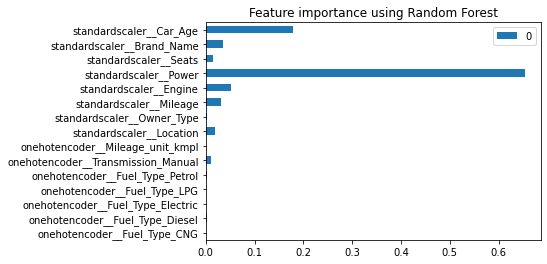

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

pip_rd=make_pipeline(ct_sc,RandomForestRegressor(random_state=10))

pip_rd.fit(x_train,y_train)

pd.DataFrame(pip_rd['randomforestregressor'].feature_importances_,pip_rd["columntransformer"].get_feature_names_out()).plot.barh()
plt.title("Feature importance using Random Forest")

<b>We observe that Owner_Type, Mileage_unit, Fuel_Type is very less importance show remove these feature and train mode again </b>

In [16]:
df_fs=df.drop(["Owner_Type",'Mileage_unit',"Fuel_Type"],axis=1)


# Create new dependent and independent variable 
x_fs=df_fs.drop('Price',axis=1)
y_fs=df_fs.Price


<b> Train model after feature selection <b/>

In [17]:
for model in models:
    summary=Training(models[model],x_fs,y_fs)
    Model_Summary=Model_Summary.append({"Model_name":model +"_FS","RSME":summary[0],
                                        "Test r2_score":summary[1],"Train r2_score":summary[2],
                                       "Variance":summary[3]},ignore_index=True)

Learning rate set to 0.051033
0:	learn: 10.8737708	total: 3.37ms	remaining: 3.36s
1:	learn: 10.4903187	total: 6.39ms	remaining: 3.19s
2:	learn: 10.1354020	total: 9.44ms	remaining: 3.14s
3:	learn: 9.7800004	total: 12.4ms	remaining: 3.09s
4:	learn: 9.4622089	total: 14.8ms	remaining: 2.95s
5:	learn: 9.1598929	total: 18ms	remaining: 2.98s
6:	learn: 8.8730325	total: 21.7ms	remaining: 3.07s
7:	learn: 8.5997907	total: 24.8ms	remaining: 3.07s
8:	learn: 8.3408780	total: 27.8ms	remaining: 3.06s
9:	learn: 8.0931989	total: 30.8ms	remaining: 3.05s
10:	learn: 7.8605034	total: 33.8ms	remaining: 3.04s
11:	learn: 7.6320449	total: 36.7ms	remaining: 3.02s
12:	learn: 7.4449580	total: 40.1ms	remaining: 3.04s
13:	learn: 7.2377093	total: 43.2ms	remaining: 3.04s
14:	learn: 7.0583898	total: 45.9ms	remaining: 3.01s
15:	learn: 6.8697624	total: 48.6ms	remaining: 2.99s
16:	learn: 6.7017153	total: 51.4ms	remaining: 2.97s
17:	learn: 6.5432132	total: 54.1ms	remaining: 2.95s
18:	learn: 6.4109349	total: 56.9ms	remainin

174:	learn: 2.9315890	total: 488ms	remaining: 2.3s
175:	learn: 2.9276444	total: 490ms	remaining: 2.29s
176:	learn: 2.9178998	total: 493ms	remaining: 2.29s
177:	learn: 2.9156664	total: 496ms	remaining: 2.29s
178:	learn: 2.9115106	total: 499ms	remaining: 2.29s
179:	learn: 2.9081134	total: 503ms	remaining: 2.29s
180:	learn: 2.8999327	total: 506ms	remaining: 2.29s
181:	learn: 2.8978461	total: 508ms	remaining: 2.28s
182:	learn: 2.8975739	total: 511ms	remaining: 2.28s
183:	learn: 2.8931729	total: 513ms	remaining: 2.27s
184:	learn: 2.8863277	total: 516ms	remaining: 2.27s
185:	learn: 2.8798487	total: 519ms	remaining: 2.27s
186:	learn: 2.8780230	total: 521ms	remaining: 2.27s
187:	learn: 2.8686281	total: 524ms	remaining: 2.26s
188:	learn: 2.8589881	total: 527ms	remaining: 2.26s
189:	learn: 2.8506975	total: 530ms	remaining: 2.26s
190:	learn: 2.8480163	total: 532ms	remaining: 2.25s
191:	learn: 2.8424599	total: 535ms	remaining: 2.25s
192:	learn: 2.8375708	total: 538ms	remaining: 2.25s
193:	learn: 2

354:	learn: 2.2172547	total: 981ms	remaining: 1.78s
355:	learn: 2.2140338	total: 984ms	remaining: 1.78s
356:	learn: 2.2127517	total: 986ms	remaining: 1.78s
357:	learn: 2.2103895	total: 989ms	remaining: 1.77s
358:	learn: 2.2081283	total: 992ms	remaining: 1.77s
359:	learn: 2.2047391	total: 995ms	remaining: 1.77s
360:	learn: 2.2040097	total: 997ms	remaining: 1.76s
361:	learn: 2.2019972	total: 1000ms	remaining: 1.76s
362:	learn: 2.2001093	total: 1s	remaining: 1.76s
363:	learn: 2.1992646	total: 1s	remaining: 1.75s
364:	learn: 2.1948435	total: 1.01s	remaining: 1.75s
365:	learn: 2.1892312	total: 1.01s	remaining: 1.75s
366:	learn: 2.1876409	total: 1.01s	remaining: 1.75s
367:	learn: 2.1825949	total: 1.01s	remaining: 1.74s
368:	learn: 2.1812318	total: 1.02s	remaining: 1.74s
369:	learn: 2.1785330	total: 1.02s	remaining: 1.74s
370:	learn: 2.1772060	total: 1.02s	remaining: 1.74s
371:	learn: 2.1760920	total: 1.03s	remaining: 1.73s
372:	learn: 2.1730441	total: 1.03s	remaining: 1.73s
373:	learn: 2.171

537:	learn: 1.8530634	total: 1.48s	remaining: 1.27s
538:	learn: 1.8512761	total: 1.48s	remaining: 1.27s
539:	learn: 1.8505040	total: 1.48s	remaining: 1.26s
540:	learn: 1.8489519	total: 1.49s	remaining: 1.26s
541:	learn: 1.8472637	total: 1.49s	remaining: 1.26s
542:	learn: 1.8449649	total: 1.49s	remaining: 1.26s
543:	learn: 1.8439473	total: 1.5s	remaining: 1.25s
544:	learn: 1.8425736	total: 1.5s	remaining: 1.25s
545:	learn: 1.8399254	total: 1.5s	remaining: 1.25s
546:	learn: 1.8375633	total: 1.5s	remaining: 1.25s
547:	learn: 1.8366004	total: 1.51s	remaining: 1.24s
548:	learn: 1.8352308	total: 1.51s	remaining: 1.24s
549:	learn: 1.8346514	total: 1.51s	remaining: 1.24s
550:	learn: 1.8311297	total: 1.51s	remaining: 1.23s
551:	learn: 1.8293695	total: 1.52s	remaining: 1.23s
552:	learn: 1.8276604	total: 1.52s	remaining: 1.23s
553:	learn: 1.8266079	total: 1.52s	remaining: 1.23s
554:	learn: 1.8260025	total: 1.53s	remaining: 1.22s
555:	learn: 1.8250724	total: 1.53s	remaining: 1.22s
556:	learn: 1.82

709:	learn: 1.6124508	total: 1.97s	remaining: 804ms
710:	learn: 1.6116783	total: 1.97s	remaining: 802ms
711:	learn: 1.6110802	total: 1.98s	remaining: 799ms
712:	learn: 1.6093215	total: 1.98s	remaining: 797ms
713:	learn: 1.6086121	total: 1.98s	remaining: 794ms
714:	learn: 1.6070972	total: 1.98s	remaining: 791ms
715:	learn: 1.6058419	total: 1.99s	remaining: 789ms
716:	learn: 1.6049496	total: 1.99s	remaining: 786ms
717:	learn: 1.6043468	total: 1.99s	remaining: 784ms
718:	learn: 1.6026328	total: 2s	remaining: 781ms
719:	learn: 1.6012093	total: 2s	remaining: 778ms
720:	learn: 1.5998687	total: 2s	remaining: 776ms
721:	learn: 1.5985354	total: 2.01s	remaining: 773ms
722:	learn: 1.5973743	total: 2.01s	remaining: 770ms
723:	learn: 1.5968482	total: 2.01s	remaining: 768ms
724:	learn: 1.5954331	total: 2.02s	remaining: 765ms
725:	learn: 1.5951381	total: 2.02s	remaining: 762ms
726:	learn: 1.5946543	total: 2.02s	remaining: 760ms
727:	learn: 1.5937727	total: 2.03s	remaining: 757ms
728:	learn: 1.5922492

869:	learn: 1.4726342	total: 2.46s	remaining: 368ms
870:	learn: 1.4722762	total: 2.46s	remaining: 365ms
871:	learn: 1.4713917	total: 2.46s	remaining: 362ms
872:	learn: 1.4710467	total: 2.47s	remaining: 359ms
873:	learn: 1.4702259	total: 2.47s	remaining: 356ms
874:	learn: 1.4692439	total: 2.47s	remaining: 353ms
875:	learn: 1.4679613	total: 2.48s	remaining: 351ms
876:	learn: 1.4674535	total: 2.48s	remaining: 348ms
877:	learn: 1.4668484	total: 2.48s	remaining: 345ms
878:	learn: 1.4663457	total: 2.48s	remaining: 342ms
879:	learn: 1.4648931	total: 2.49s	remaining: 339ms
880:	learn: 1.4645813	total: 2.49s	remaining: 336ms
881:	learn: 1.4642706	total: 2.49s	remaining: 334ms
882:	learn: 1.4639705	total: 2.5s	remaining: 331ms
883:	learn: 1.4638075	total: 2.5s	remaining: 328ms
884:	learn: 1.4628568	total: 2.5s	remaining: 325ms
885:	learn: 1.4622813	total: 2.5s	remaining: 322ms
886:	learn: 1.4613667	total: 2.51s	remaining: 319ms
887:	learn: 1.4607431	total: 2.51s	remaining: 317ms
888:	learn: 1.46

49:	learn: 4.2098429	total: 157ms	remaining: 2.98s
50:	learn: 4.1767621	total: 160ms	remaining: 2.98s
51:	learn: 4.1512673	total: 163ms	remaining: 2.97s
52:	learn: 4.1224241	total: 166ms	remaining: 2.96s
53:	learn: 4.0979700	total: 169ms	remaining: 2.96s
54:	learn: 4.0713309	total: 172ms	remaining: 2.95s
55:	learn: 4.0451044	total: 174ms	remaining: 2.94s
56:	learn: 4.0250973	total: 177ms	remaining: 2.93s
57:	learn: 4.0036947	total: 180ms	remaining: 2.92s
58:	learn: 3.9753643	total: 184ms	remaining: 2.93s
59:	learn: 3.9472835	total: 187ms	remaining: 2.92s
60:	learn: 3.9302836	total: 189ms	remaining: 2.91s
61:	learn: 3.9111280	total: 192ms	remaining: 2.9s
62:	learn: 3.8946937	total: 194ms	remaining: 2.89s
63:	learn: 3.8739431	total: 197ms	remaining: 2.89s
64:	learn: 3.8553187	total: 200ms	remaining: 2.88s
65:	learn: 3.8451938	total: 203ms	remaining: 2.88s
66:	learn: 3.8239438	total: 206ms	remaining: 2.87s
67:	learn: 3.8080179	total: 209ms	remaining: 2.86s
68:	learn: 3.7874559	total: 211m

229:	learn: 2.6674921	total: 647ms	remaining: 2.17s
230:	learn: 2.6607445	total: 650ms	remaining: 2.16s
231:	learn: 2.6541890	total: 653ms	remaining: 2.16s
232:	learn: 2.6484011	total: 655ms	remaining: 2.16s
233:	learn: 2.6454235	total: 658ms	remaining: 2.15s
234:	learn: 2.6391531	total: 661ms	remaining: 2.15s
235:	learn: 2.6331060	total: 664ms	remaining: 2.15s
236:	learn: 2.6328822	total: 666ms	remaining: 2.14s
237:	learn: 2.6326801	total: 669ms	remaining: 2.14s
238:	learn: 2.6292552	total: 671ms	remaining: 2.14s
239:	learn: 2.6236847	total: 674ms	remaining: 2.13s
240:	learn: 2.6179289	total: 677ms	remaining: 2.13s
241:	learn: 2.6163861	total: 679ms	remaining: 2.13s
242:	learn: 2.6103775	total: 682ms	remaining: 2.12s
243:	learn: 2.6047533	total: 685ms	remaining: 2.12s
244:	learn: 2.5991026	total: 688ms	remaining: 2.12s
245:	learn: 2.5931537	total: 690ms	remaining: 2.12s
246:	learn: 2.5929640	total: 693ms	remaining: 2.11s
247:	learn: 2.5891986	total: 695ms	remaining: 2.11s
248:	learn: 

415:	learn: 2.0734050	total: 1.14s	remaining: 1.61s
416:	learn: 2.0716534	total: 1.15s	remaining: 1.6s
417:	learn: 2.0692201	total: 1.15s	remaining: 1.6s
418:	learn: 2.0664786	total: 1.15s	remaining: 1.6s
419:	learn: 2.0645825	total: 1.15s	remaining: 1.59s
420:	learn: 2.0619182	total: 1.16s	remaining: 1.59s
421:	learn: 2.0594430	total: 1.16s	remaining: 1.59s
422:	learn: 2.0589340	total: 1.16s	remaining: 1.59s
423:	learn: 2.0565319	total: 1.17s	remaining: 1.58s
424:	learn: 2.0554232	total: 1.17s	remaining: 1.58s
425:	learn: 2.0547029	total: 1.17s	remaining: 1.58s
426:	learn: 2.0540164	total: 1.17s	remaining: 1.57s
427:	learn: 2.0531283	total: 1.18s	remaining: 1.57s
428:	learn: 2.0508232	total: 1.18s	remaining: 1.57s
429:	learn: 2.0498100	total: 1.18s	remaining: 1.56s
430:	learn: 2.0452597	total: 1.18s	remaining: 1.56s
431:	learn: 2.0447645	total: 1.19s	remaining: 1.56s
432:	learn: 2.0397550	total: 1.19s	remaining: 1.56s
433:	learn: 2.0354631	total: 1.19s	remaining: 1.55s
434:	learn: 2.0

596:	learn: 1.7585217	total: 1.64s	remaining: 1.11s
597:	learn: 1.7571613	total: 1.64s	remaining: 1.1s
598:	learn: 1.7561878	total: 1.64s	remaining: 1.1s
599:	learn: 1.7548435	total: 1.65s	remaining: 1.1s
600:	learn: 1.7525142	total: 1.65s	remaining: 1.09s
601:	learn: 1.7511494	total: 1.65s	remaining: 1.09s
602:	learn: 1.7497793	total: 1.66s	remaining: 1.09s
603:	learn: 1.7470703	total: 1.66s	remaining: 1.09s
604:	learn: 1.7457720	total: 1.66s	remaining: 1.08s
605:	learn: 1.7435955	total: 1.66s	remaining: 1.08s
606:	learn: 1.7421437	total: 1.67s	remaining: 1.08s
607:	learn: 1.7404388	total: 1.67s	remaining: 1.08s
608:	learn: 1.7388241	total: 1.67s	remaining: 1.07s
609:	learn: 1.7370157	total: 1.67s	remaining: 1.07s
610:	learn: 1.7356820	total: 1.68s	remaining: 1.07s
611:	learn: 1.7339408	total: 1.68s	remaining: 1.06s
612:	learn: 1.7323427	total: 1.68s	remaining: 1.06s
613:	learn: 1.7314949	total: 1.69s	remaining: 1.06s
614:	learn: 1.7291386	total: 1.69s	remaining: 1.06s
615:	learn: 1.7

776:	learn: 1.5513858	total: 2.13s	remaining: 612ms
777:	learn: 1.5510743	total: 2.14s	remaining: 610ms
778:	learn: 1.5498719	total: 2.14s	remaining: 607ms
779:	learn: 1.5495027	total: 2.14s	remaining: 604ms
780:	learn: 1.5475696	total: 2.14s	remaining: 601ms
781:	learn: 1.5471851	total: 2.15s	remaining: 599ms
782:	learn: 1.5461303	total: 2.15s	remaining: 596ms
783:	learn: 1.5455766	total: 2.15s	remaining: 593ms
784:	learn: 1.5450725	total: 2.16s	remaining: 591ms
785:	learn: 1.5444645	total: 2.16s	remaining: 588ms
786:	learn: 1.5437784	total: 2.16s	remaining: 585ms
787:	learn: 1.5418728	total: 2.16s	remaining: 582ms
788:	learn: 1.5411844	total: 2.17s	remaining: 580ms
789:	learn: 1.5393232	total: 2.17s	remaining: 577ms
790:	learn: 1.5388218	total: 2.17s	remaining: 574ms
791:	learn: 1.5380493	total: 2.17s	remaining: 571ms
792:	learn: 1.5375975	total: 2.18s	remaining: 569ms
793:	learn: 1.5361342	total: 2.18s	remaining: 566ms
794:	learn: 1.5354666	total: 2.18s	remaining: 563ms
795:	learn: 

939:	learn: 1.4218213	total: 2.62s	remaining: 167ms
940:	learn: 1.4214480	total: 2.63s	remaining: 165ms
941:	learn: 1.4204822	total: 2.63s	remaining: 162ms
942:	learn: 1.4193175	total: 2.64s	remaining: 159ms
943:	learn: 1.4184489	total: 2.64s	remaining: 157ms
944:	learn: 1.4180762	total: 2.64s	remaining: 154ms
945:	learn: 1.4174292	total: 2.64s	remaining: 151ms
946:	learn: 1.4172785	total: 2.65s	remaining: 148ms
947:	learn: 1.4163150	total: 2.65s	remaining: 145ms
948:	learn: 1.4154850	total: 2.65s	remaining: 143ms
949:	learn: 1.4145336	total: 2.66s	remaining: 140ms
950:	learn: 1.4135637	total: 2.66s	remaining: 137ms
951:	learn: 1.4130919	total: 2.66s	remaining: 134ms
952:	learn: 1.4122980	total: 2.67s	remaining: 132ms
953:	learn: 1.4110438	total: 2.67s	remaining: 129ms
954:	learn: 1.4097782	total: 2.67s	remaining: 126ms
955:	learn: 1.4090553	total: 2.68s	remaining: 123ms
956:	learn: 1.4082511	total: 2.68s	remaining: 120ms
957:	learn: 1.4073446	total: 2.68s	remaining: 118ms
958:	learn: 

117:	learn: 3.2810585	total: 321ms	remaining: 2.4s
118:	learn: 3.2762095	total: 324ms	remaining: 2.4s
119:	learn: 3.2755261	total: 325ms	remaining: 2.38s
120:	learn: 3.2614744	total: 328ms	remaining: 2.38s
121:	learn: 3.2478161	total: 331ms	remaining: 2.38s
122:	learn: 3.2426578	total: 333ms	remaining: 2.38s
123:	learn: 3.2392395	total: 336ms	remaining: 2.37s
124:	learn: 3.2358079	total: 338ms	remaining: 2.37s
125:	learn: 3.2327276	total: 341ms	remaining: 2.36s
126:	learn: 3.2238399	total: 344ms	remaining: 2.36s
127:	learn: 3.2223745	total: 346ms	remaining: 2.36s
128:	learn: 3.2100097	total: 349ms	remaining: 2.36s
129:	learn: 3.2053425	total: 352ms	remaining: 2.35s
130:	learn: 3.1993721	total: 355ms	remaining: 2.35s
131:	learn: 3.1913519	total: 357ms	remaining: 2.35s
132:	learn: 3.1883647	total: 360ms	remaining: 2.35s
133:	learn: 3.1793937	total: 363ms	remaining: 2.34s
134:	learn: 3.1741556	total: 365ms	remaining: 2.34s
135:	learn: 3.1694376	total: 368ms	remaining: 2.34s
136:	learn: 3.

303:	learn: 2.3687313	total: 813ms	remaining: 1.86s
304:	learn: 2.3670368	total: 816ms	remaining: 1.86s
305:	learn: 2.3654249	total: 818ms	remaining: 1.86s
306:	learn: 2.3601094	total: 821ms	remaining: 1.85s
307:	learn: 2.3594608	total: 823ms	remaining: 1.85s
308:	learn: 2.3565854	total: 826ms	remaining: 1.85s
309:	learn: 2.3524957	total: 828ms	remaining: 1.84s
310:	learn: 2.3519682	total: 830ms	remaining: 1.84s
311:	learn: 2.3477234	total: 833ms	remaining: 1.84s
312:	learn: 2.3430545	total: 836ms	remaining: 1.83s
313:	learn: 2.3380844	total: 839ms	remaining: 1.83s
314:	learn: 2.3371120	total: 841ms	remaining: 1.83s
315:	learn: 2.3334975	total: 844ms	remaining: 1.83s
316:	learn: 2.3319664	total: 847ms	remaining: 1.82s
317:	learn: 2.3293880	total: 850ms	remaining: 1.82s
318:	learn: 2.3265908	total: 853ms	remaining: 1.82s
319:	learn: 2.3228988	total: 855ms	remaining: 1.82s
320:	learn: 2.3167036	total: 858ms	remaining: 1.81s
321:	learn: 2.3109997	total: 861ms	remaining: 1.81s
322:	learn: 

487:	learn: 1.9317427	total: 1.31s	remaining: 1.38s
488:	learn: 1.9310379	total: 1.31s	remaining: 1.37s
489:	learn: 1.9291836	total: 1.32s	remaining: 1.37s
490:	learn: 1.9277137	total: 1.32s	remaining: 1.37s
491:	learn: 1.9268314	total: 1.32s	remaining: 1.36s
492:	learn: 1.9254364	total: 1.32s	remaining: 1.36s
493:	learn: 1.9233364	total: 1.33s	remaining: 1.36s
494:	learn: 1.9205402	total: 1.33s	remaining: 1.36s
495:	learn: 1.9187960	total: 1.33s	remaining: 1.35s
496:	learn: 1.9171773	total: 1.33s	remaining: 1.35s
497:	learn: 1.9148904	total: 1.34s	remaining: 1.35s
498:	learn: 1.9129865	total: 1.34s	remaining: 1.35s
499:	learn: 1.9111798	total: 1.34s	remaining: 1.34s
500:	learn: 1.9095374	total: 1.35s	remaining: 1.34s
501:	learn: 1.9088410	total: 1.35s	remaining: 1.34s
502:	learn: 1.9066758	total: 1.35s	remaining: 1.34s
503:	learn: 1.9046601	total: 1.35s	remaining: 1.33s
504:	learn: 1.9031828	total: 1.36s	remaining: 1.33s
505:	learn: 1.9025538	total: 1.36s	remaining: 1.33s
506:	learn: 

668:	learn: 1.6606535	total: 1.81s	remaining: 894ms
669:	learn: 1.6588416	total: 1.81s	remaining: 892ms
670:	learn: 1.6572820	total: 1.81s	remaining: 889ms
671:	learn: 1.6561970	total: 1.81s	remaining: 886ms
672:	learn: 1.6554654	total: 1.82s	remaining: 883ms
673:	learn: 1.6542972	total: 1.82s	remaining: 881ms
674:	learn: 1.6534068	total: 1.82s	remaining: 878ms
675:	learn: 1.6521462	total: 1.83s	remaining: 875ms
676:	learn: 1.6502086	total: 1.83s	remaining: 873ms
677:	learn: 1.6490324	total: 1.83s	remaining: 870ms
678:	learn: 1.6475211	total: 1.83s	remaining: 867ms
679:	learn: 1.6451171	total: 1.84s	remaining: 864ms
680:	learn: 1.6441554	total: 1.84s	remaining: 862ms
681:	learn: 1.6422930	total: 1.84s	remaining: 859ms
682:	learn: 1.6408112	total: 1.84s	remaining: 856ms
683:	learn: 1.6403797	total: 1.85s	remaining: 854ms
684:	learn: 1.6387377	total: 1.85s	remaining: 851ms
685:	learn: 1.6377639	total: 1.85s	remaining: 849ms
686:	learn: 1.6365329	total: 1.86s	remaining: 846ms
687:	learn: 

854:	learn: 1.4836601	total: 2.31s	remaining: 392ms
855:	learn: 1.4833078	total: 2.31s	remaining: 389ms
856:	learn: 1.4820100	total: 2.31s	remaining: 386ms
857:	learn: 1.4814175	total: 2.32s	remaining: 384ms
858:	learn: 1.4809683	total: 2.32s	remaining: 381ms
859:	learn: 1.4798037	total: 2.32s	remaining: 378ms
860:	learn: 1.4790896	total: 2.33s	remaining: 375ms
861:	learn: 1.4784939	total: 2.33s	remaining: 373ms
862:	learn: 1.4773892	total: 2.33s	remaining: 370ms
863:	learn: 1.4767163	total: 2.33s	remaining: 367ms
864:	learn: 1.4759754	total: 2.34s	remaining: 365ms
865:	learn: 1.4754698	total: 2.34s	remaining: 362ms
866:	learn: 1.4752096	total: 2.34s	remaining: 359ms
867:	learn: 1.4742034	total: 2.34s	remaining: 357ms
868:	learn: 1.4735893	total: 2.35s	remaining: 354ms
869:	learn: 1.4726342	total: 2.35s	remaining: 351ms
870:	learn: 1.4722762	total: 2.35s	remaining: 348ms
871:	learn: 1.4713917	total: 2.35s	remaining: 346ms
872:	learn: 1.4710467	total: 2.36s	remaining: 343ms
873:	learn: 

60:	learn: 4.0272405	total: 157ms	remaining: 2.42s
61:	learn: 3.9996292	total: 160ms	remaining: 2.42s
62:	learn: 3.9809216	total: 162ms	remaining: 2.41s
63:	learn: 3.9572267	total: 165ms	remaining: 2.41s
64:	learn: 3.9419907	total: 168ms	remaining: 2.41s
65:	learn: 3.9285026	total: 171ms	remaining: 2.41s
66:	learn: 3.9122430	total: 173ms	remaining: 2.41s
67:	learn: 3.8948591	total: 176ms	remaining: 2.41s
68:	learn: 3.8785135	total: 178ms	remaining: 2.41s
69:	learn: 3.8671682	total: 181ms	remaining: 2.4s
70:	learn: 3.8647136	total: 183ms	remaining: 2.4s
71:	learn: 3.8530822	total: 186ms	remaining: 2.4s
72:	learn: 3.8507059	total: 188ms	remaining: 2.38s
73:	learn: 3.8352623	total: 190ms	remaining: 2.38s
74:	learn: 3.8227777	total: 193ms	remaining: 2.38s
75:	learn: 3.8065363	total: 196ms	remaining: 2.38s
76:	learn: 3.7952302	total: 198ms	remaining: 2.38s
77:	learn: 3.7850871	total: 201ms	remaining: 2.38s
78:	learn: 3.7716081	total: 204ms	remaining: 2.37s
79:	learn: 3.7540246	total: 207ms	

256:	learn: 2.6002597	total: 646ms	remaining: 1.87s
257:	learn: 2.5994990	total: 649ms	remaining: 1.86s
258:	learn: 2.5943745	total: 651ms	remaining: 1.86s
259:	learn: 2.5936619	total: 654ms	remaining: 1.86s
260:	learn: 2.5932442	total: 656ms	remaining: 1.86s
261:	learn: 2.5925909	total: 658ms	remaining: 1.85s
262:	learn: 2.5858889	total: 661ms	remaining: 1.85s
263:	learn: 2.5784752	total: 663ms	remaining: 1.85s
264:	learn: 2.5713621	total: 666ms	remaining: 1.85s
265:	learn: 2.5662586	total: 668ms	remaining: 1.84s
266:	learn: 2.5658645	total: 671ms	remaining: 1.84s
267:	learn: 2.5589462	total: 673ms	remaining: 1.84s
268:	learn: 2.5542783	total: 676ms	remaining: 1.84s
269:	learn: 2.5485387	total: 679ms	remaining: 1.83s
270:	learn: 2.5479261	total: 681ms	remaining: 1.83s
271:	learn: 2.5399665	total: 684ms	remaining: 1.83s
272:	learn: 2.5327766	total: 687ms	remaining: 1.83s
273:	learn: 2.5326192	total: 689ms	remaining: 1.82s
274:	learn: 2.5317356	total: 692ms	remaining: 1.82s
275:	learn: 

447:	learn: 2.0612713	total: 1.14s	remaining: 1.41s
448:	learn: 2.0592084	total: 1.15s	remaining: 1.41s
449:	learn: 2.0557987	total: 1.15s	remaining: 1.4s
450:	learn: 2.0540655	total: 1.15s	remaining: 1.4s
451:	learn: 2.0523530	total: 1.15s	remaining: 1.4s
452:	learn: 2.0497413	total: 1.16s	remaining: 1.4s
453:	learn: 2.0493213	total: 1.16s	remaining: 1.39s
454:	learn: 2.0478715	total: 1.16s	remaining: 1.39s
455:	learn: 2.0478087	total: 1.17s	remaining: 1.39s
456:	learn: 2.0462080	total: 1.17s	remaining: 1.39s
457:	learn: 2.0429334	total: 1.17s	remaining: 1.39s
458:	learn: 2.0418482	total: 1.17s	remaining: 1.38s
459:	learn: 2.0387260	total: 1.18s	remaining: 1.38s
460:	learn: 2.0380422	total: 1.18s	remaining: 1.38s
461:	learn: 2.0341058	total: 1.18s	remaining: 1.38s
462:	learn: 2.0313733	total: 1.18s	remaining: 1.37s
463:	learn: 2.0300923	total: 1.19s	remaining: 1.37s
464:	learn: 2.0267744	total: 1.19s	remaining: 1.37s
465:	learn: 2.0236715	total: 1.19s	remaining: 1.37s
466:	learn: 2.02

658:	learn: 1.6967643	total: 1.78s	remaining: 921ms
659:	learn: 1.6957426	total: 1.78s	remaining: 918ms
660:	learn: 1.6942749	total: 1.78s	remaining: 916ms
661:	learn: 1.6926044	total: 1.79s	remaining: 913ms
662:	learn: 1.6914873	total: 1.79s	remaining: 910ms
663:	learn: 1.6898380	total: 1.79s	remaining: 907ms
664:	learn: 1.6880833	total: 1.79s	remaining: 905ms
665:	learn: 1.6875179	total: 1.8s	remaining: 902ms
666:	learn: 1.6869529	total: 1.8s	remaining: 899ms
667:	learn: 1.6857035	total: 1.8s	remaining: 896ms
668:	learn: 1.6839904	total: 1.81s	remaining: 894ms
669:	learn: 1.6831964	total: 1.81s	remaining: 891ms
670:	learn: 1.6807561	total: 1.81s	remaining: 888ms
671:	learn: 1.6797495	total: 1.81s	remaining: 886ms
672:	learn: 1.6789918	total: 1.82s	remaining: 883ms
673:	learn: 1.6774741	total: 1.82s	remaining: 880ms
674:	learn: 1.6752030	total: 1.82s	remaining: 878ms
675:	learn: 1.6738100	total: 1.82s	remaining: 875ms
676:	learn: 1.6728248	total: 1.83s	remaining: 873ms
677:	learn: 1.6

834:	learn: 1.4798585	total: 2.27s	remaining: 448ms
835:	learn: 1.4782141	total: 2.27s	remaining: 445ms
836:	learn: 1.4777405	total: 2.27s	remaining: 442ms
837:	learn: 1.4766879	total: 2.27s	remaining: 440ms
838:	learn: 1.4760242	total: 2.28s	remaining: 437ms
839:	learn: 1.4753914	total: 2.28s	remaining: 434ms
840:	learn: 1.4749740	total: 2.28s	remaining: 431ms
841:	learn: 1.4738664	total: 2.28s	remaining: 429ms
842:	learn: 1.4730232	total: 2.29s	remaining: 426ms
843:	learn: 1.4726187	total: 2.29s	remaining: 423ms
844:	learn: 1.4708063	total: 2.29s	remaining: 420ms
845:	learn: 1.4698025	total: 2.29s	remaining: 418ms
846:	learn: 1.4682955	total: 2.3s	remaining: 415ms
847:	learn: 1.4672026	total: 2.3s	remaining: 412ms
848:	learn: 1.4658711	total: 2.3s	remaining: 409ms
849:	learn: 1.4655876	total: 2.3s	remaining: 407ms
850:	learn: 1.4651576	total: 2.31s	remaining: 404ms
851:	learn: 1.4640407	total: 2.31s	remaining: 401ms
852:	learn: 1.4630691	total: 2.31s	remaining: 398ms
853:	learn: 1.46

1:	learn: 9.9363962	total: 5.54ms	remaining: 2.76s
2:	learn: 9.6165261	total: 8.18ms	remaining: 2.72s
3:	learn: 9.2925856	total: 11ms	remaining: 2.73s
4:	learn: 8.9906207	total: 13.6ms	remaining: 2.7s
5:	learn: 8.7055920	total: 16.1ms	remaining: 2.67s
6:	learn: 8.4453433	total: 18.6ms	remaining: 2.64s
7:	learn: 8.1959982	total: 21.1ms	remaining: 2.62s
8:	learn: 7.9649625	total: 23.8ms	remaining: 2.62s
9:	learn: 7.7362669	total: 26.4ms	remaining: 2.61s
10:	learn: 7.5268173	total: 29ms	remaining: 2.6s
11:	learn: 7.3170476	total: 31.7ms	remaining: 2.61s
12:	learn: 7.1330230	total: 34.4ms	remaining: 2.61s
13:	learn: 6.9567018	total: 37ms	remaining: 2.61s
14:	learn: 6.7831741	total: 39ms	remaining: 2.56s
15:	learn: 6.6401768	total: 41.6ms	remaining: 2.56s
16:	learn: 6.4870527	total: 44.2ms	remaining: 2.56s
17:	learn: 6.3395835	total: 46.7ms	remaining: 2.55s
18:	learn: 6.2141644	total: 49.4ms	remaining: 2.55s
19:	learn: 6.0870434	total: 51.9ms	remaining: 2.54s
20:	learn: 5.9734535	total: 54.

189:	learn: 2.5862341	total: 495ms	remaining: 2.11s
190:	learn: 2.5805355	total: 497ms	remaining: 2.11s
191:	learn: 2.5778840	total: 500ms	remaining: 2.1s
192:	learn: 2.5729831	total: 503ms	remaining: 2.1s
193:	learn: 2.5674659	total: 506ms	remaining: 2.1s
194:	learn: 2.5623082	total: 508ms	remaining: 2.1s
195:	learn: 2.5600960	total: 511ms	remaining: 2.1s
196:	learn: 2.5558509	total: 513ms	remaining: 2.09s
197:	learn: 2.5507849	total: 516ms	remaining: 2.09s
198:	learn: 2.5424571	total: 519ms	remaining: 2.09s
199:	learn: 2.5414702	total: 521ms	remaining: 2.08s
200:	learn: 2.5372381	total: 524ms	remaining: 2.08s
201:	learn: 2.5364597	total: 526ms	remaining: 2.08s
202:	learn: 2.5330546	total: 528ms	remaining: 2.07s
203:	learn: 2.5311280	total: 531ms	remaining: 2.07s
204:	learn: 2.5300662	total: 533ms	remaining: 2.07s
205:	learn: 2.5240017	total: 536ms	remaining: 2.06s
206:	learn: 2.5197619	total: 538ms	remaining: 2.06s
207:	learn: 2.5186896	total: 541ms	remaining: 2.06s
208:	learn: 2.516

356:	learn: 2.0083943	total: 974ms	remaining: 1.75s
357:	learn: 2.0070083	total: 977ms	remaining: 1.75s
358:	learn: 2.0034565	total: 980ms	remaining: 1.75s
359:	learn: 2.0002054	total: 983ms	remaining: 1.75s
360:	learn: 1.9972220	total: 985ms	remaining: 1.74s
361:	learn: 1.9950567	total: 989ms	remaining: 1.74s
362:	learn: 1.9928586	total: 992ms	remaining: 1.74s
363:	learn: 1.9915757	total: 995ms	remaining: 1.74s
364:	learn: 1.9898588	total: 998ms	remaining: 1.74s
365:	learn: 1.9886326	total: 1s	remaining: 1.74s
366:	learn: 1.9885356	total: 1s	remaining: 1.73s
367:	learn: 1.9851815	total: 1.02s	remaining: 1.75s
368:	learn: 1.9840577	total: 1.02s	remaining: 1.75s
369:	learn: 1.9820708	total: 1.03s	remaining: 1.75s
370:	learn: 1.9784952	total: 1.03s	remaining: 1.75s
371:	learn: 1.9784054	total: 1.04s	remaining: 1.75s
372:	learn: 1.9773248	total: 1.04s	remaining: 1.75s
373:	learn: 1.9743404	total: 1.04s	remaining: 1.75s
374:	learn: 1.9710612	total: 1.05s	remaining: 1.75s
375:	learn: 1.9682

551:	learn: 1.6658302	total: 1.78s	remaining: 1.45s
552:	learn: 1.6638508	total: 1.79s	remaining: 1.44s
553:	learn: 1.6626157	total: 1.79s	remaining: 1.44s
554:	learn: 1.6608879	total: 1.8s	remaining: 1.44s
555:	learn: 1.6594722	total: 1.8s	remaining: 1.44s
556:	learn: 1.6573367	total: 1.81s	remaining: 1.44s
557:	learn: 1.6561075	total: 1.81s	remaining: 1.44s
558:	learn: 1.6540621	total: 1.82s	remaining: 1.44s
559:	learn: 1.6525666	total: 1.82s	remaining: 1.43s
560:	learn: 1.6514182	total: 1.83s	remaining: 1.43s
561:	learn: 1.6490876	total: 1.83s	remaining: 1.43s
562:	learn: 1.6471410	total: 1.84s	remaining: 1.43s
563:	learn: 1.6456088	total: 1.84s	remaining: 1.42s
564:	learn: 1.6447237	total: 1.85s	remaining: 1.42s
565:	learn: 1.6436476	total: 1.85s	remaining: 1.42s
566:	learn: 1.6422946	total: 1.85s	remaining: 1.42s
567:	learn: 1.6404115	total: 1.86s	remaining: 1.41s
568:	learn: 1.6383398	total: 1.86s	remaining: 1.41s
569:	learn: 1.6370620	total: 1.87s	remaining: 1.41s
570:	learn: 1.

722:	learn: 1.4564012	total: 2.62s	remaining: 1s
723:	learn: 1.4554857	total: 2.62s	remaining: 1s
724:	learn: 1.4544390	total: 2.63s	remaining: 997ms
725:	learn: 1.4534156	total: 2.63s	remaining: 993ms
726:	learn: 1.4527378	total: 2.63s	remaining: 989ms
727:	learn: 1.4520704	total: 2.64s	remaining: 986ms
728:	learn: 1.4513519	total: 2.64s	remaining: 982ms
729:	learn: 1.4499209	total: 2.65s	remaining: 979ms
730:	learn: 1.4489953	total: 2.65s	remaining: 975ms
731:	learn: 1.4481474	total: 2.65s	remaining: 972ms
732:	learn: 1.4467018	total: 2.66s	remaining: 969ms
733:	learn: 1.4458319	total: 2.66s	remaining: 965ms
734:	learn: 1.4447533	total: 2.67s	remaining: 963ms
735:	learn: 1.4442311	total: 2.67s	remaining: 959ms
736:	learn: 1.4423709	total: 2.68s	remaining: 955ms
737:	learn: 1.4419960	total: 2.68s	remaining: 951ms
738:	learn: 1.4410635	total: 2.68s	remaining: 948ms
739:	learn: 1.4405972	total: 2.69s	remaining: 944ms
740:	learn: 1.4402146	total: 2.69s	remaining: 941ms
741:	learn: 1.4389

887:	learn: 1.3185893	total: 3.45s	remaining: 435ms
888:	learn: 1.3180505	total: 3.45s	remaining: 431ms
889:	learn: 1.3175339	total: 3.46s	remaining: 427ms
890:	learn: 1.3166187	total: 3.46s	remaining: 424ms
891:	learn: 1.3157803	total: 3.47s	remaining: 420ms
892:	learn: 1.3149890	total: 3.47s	remaining: 416ms
893:	learn: 1.3143340	total: 3.48s	remaining: 412ms
894:	learn: 1.3125980	total: 3.48s	remaining: 408ms
895:	learn: 1.3117773	total: 3.48s	remaining: 404ms
896:	learn: 1.3112389	total: 3.49s	remaining: 401ms
897:	learn: 1.3105890	total: 3.49s	remaining: 397ms
898:	learn: 1.3097721	total: 3.5s	remaining: 393ms
899:	learn: 1.3086530	total: 3.5s	remaining: 389ms
900:	learn: 1.3076563	total: 3.5s	remaining: 385ms
901:	learn: 1.3069345	total: 3.51s	remaining: 381ms
902:	learn: 1.3062858	total: 3.51s	remaining: 377ms
903:	learn: 1.3057192	total: 3.52s	remaining: 373ms
904:	learn: 1.3049454	total: 3.52s	remaining: 370ms
905:	learn: 1.3043682	total: 3.53s	remaining: 366ms
906:	learn: 1.3

45:	learn: 4.6314509	total: 160ms	remaining: 3.33s
46:	learn: 4.5926919	total: 164ms	remaining: 3.33s
47:	learn: 4.5469270	total: 168ms	remaining: 3.34s
48:	learn: 4.5084881	total: 172ms	remaining: 3.34s
49:	learn: 4.4753374	total: 176ms	remaining: 3.34s
50:	learn: 4.4423529	total: 179ms	remaining: 3.34s
51:	learn: 4.4150464	total: 183ms	remaining: 3.34s
52:	learn: 4.3837202	total: 187ms	remaining: 3.34s
53:	learn: 4.3524774	total: 190ms	remaining: 3.33s
54:	learn: 4.3247477	total: 193ms	remaining: 3.32s
55:	learn: 4.3001618	total: 196ms	remaining: 3.31s
56:	learn: 4.2774496	total: 201ms	remaining: 3.32s
57:	learn: 4.2456904	total: 204ms	remaining: 3.31s
58:	learn: 4.2214337	total: 208ms	remaining: 3.32s
59:	learn: 4.1916591	total: 213ms	remaining: 3.33s
60:	learn: 4.1663931	total: 217ms	remaining: 3.34s
61:	learn: 4.1444603	total: 224ms	remaining: 3.38s
62:	learn: 4.1263229	total: 229ms	remaining: 3.4s
63:	learn: 4.1037406	total: 232ms	remaining: 3.39s
64:	learn: 4.0788218	total: 237m

222:	learn: 2.7905443	total: 983ms	remaining: 3.43s
223:	learn: 2.7902736	total: 987ms	remaining: 3.42s
224:	learn: 2.7856077	total: 991ms	remaining: 3.41s
225:	learn: 2.7791748	total: 995ms	remaining: 3.41s
226:	learn: 2.7789070	total: 999ms	remaining: 3.4s
227:	learn: 2.7747186	total: 1s	remaining: 3.4s
228:	learn: 2.7744676	total: 1.01s	remaining: 3.4s
229:	learn: 2.7683452	total: 1.01s	remaining: 3.39s
230:	learn: 2.7680624	total: 1.02s	remaining: 3.38s
231:	learn: 2.7644377	total: 1.02s	remaining: 3.38s
232:	learn: 2.7579020	total: 1.03s	remaining: 3.38s
233:	learn: 2.7567121	total: 1.03s	remaining: 3.38s
234:	learn: 2.7507307	total: 1.03s	remaining: 3.37s
235:	learn: 2.7487055	total: 1.04s	remaining: 3.36s
236:	learn: 2.7484465	total: 1.05s	remaining: 3.39s
237:	learn: 2.7417266	total: 1.06s	remaining: 3.4s
238:	learn: 2.7352963	total: 1.06s	remaining: 3.39s
239:	learn: 2.7288294	total: 1.07s	remaining: 3.38s
240:	learn: 2.7258706	total: 1.07s	remaining: 3.38s
241:	learn: 2.72322

399:	learn: 2.1974728	total: 1.99s	remaining: 2.98s
400:	learn: 2.1956665	total: 1.99s	remaining: 2.97s
401:	learn: 2.1917551	total: 1.99s	remaining: 2.96s
402:	learn: 2.1885895	total: 2s	remaining: 2.96s
403:	learn: 2.1865529	total: 2s	remaining: 2.95s
404:	learn: 2.1858954	total: 2s	remaining: 2.94s
405:	learn: 2.1831321	total: 2.01s	remaining: 2.94s
406:	learn: 2.1805286	total: 2.01s	remaining: 2.93s
407:	learn: 2.1792844	total: 2.02s	remaining: 2.93s
408:	learn: 2.1765851	total: 2.02s	remaining: 2.92s
409:	learn: 2.1751811	total: 2.02s	remaining: 2.91s
410:	learn: 2.1732202	total: 2.03s	remaining: 2.91s
411:	learn: 2.1703201	total: 2.04s	remaining: 2.91s
412:	learn: 2.1699805	total: 2.04s	remaining: 2.9s
413:	learn: 2.1666766	total: 2.04s	remaining: 2.89s
414:	learn: 2.1638076	total: 2.05s	remaining: 2.89s
415:	learn: 2.1608131	total: 2.08s	remaining: 2.92s
416:	learn: 2.1583875	total: 2.08s	remaining: 2.91s
417:	learn: 2.1546505	total: 2.09s	remaining: 2.91s
418:	learn: 2.1543021	

599:	learn: 1.7852219	total: 2.8s	remaining: 1.86s
600:	learn: 1.7835753	total: 2.8s	remaining: 1.86s
601:	learn: 1.7821508	total: 2.8s	remaining: 1.85s
602:	learn: 1.7803820	total: 2.81s	remaining: 1.85s
603:	learn: 1.7791582	total: 2.81s	remaining: 1.84s
604:	learn: 1.7771668	total: 2.82s	remaining: 1.84s
605:	learn: 1.7756000	total: 2.82s	remaining: 1.83s
606:	learn: 1.7732834	total: 2.82s	remaining: 1.83s
607:	learn: 1.7716273	total: 2.83s	remaining: 1.82s
608:	learn: 1.7698186	total: 2.83s	remaining: 1.82s
609:	learn: 1.7693160	total: 2.83s	remaining: 1.81s
610:	learn: 1.7678275	total: 2.83s	remaining: 1.8s
611:	learn: 1.7662060	total: 2.84s	remaining: 1.8s
612:	learn: 1.7643739	total: 2.84s	remaining: 1.79s
613:	learn: 1.7633025	total: 2.85s	remaining: 1.79s
614:	learn: 1.7621953	total: 2.85s	remaining: 1.78s
615:	learn: 1.7606668	total: 2.85s	remaining: 1.78s
616:	learn: 1.7592682	total: 2.85s	remaining: 1.77s
617:	learn: 1.7588087	total: 2.86s	remaining: 1.77s
618:	learn: 1.756

763:	learn: 1.5663897	total: 3.45s	remaining: 1.06s
764:	learn: 1.5650532	total: 3.45s	remaining: 1.06s
765:	learn: 1.5639286	total: 3.46s	remaining: 1.05s
766:	learn: 1.5632673	total: 3.46s	remaining: 1.05s
767:	learn: 1.5613849	total: 3.46s	remaining: 1.05s
768:	learn: 1.5600529	total: 3.47s	remaining: 1.04s
769:	learn: 1.5592999	total: 3.47s	remaining: 1.04s
770:	learn: 1.5580756	total: 3.48s	remaining: 1.03s
771:	learn: 1.5564167	total: 3.48s	remaining: 1.03s
772:	learn: 1.5554071	total: 3.49s	remaining: 1.02s
773:	learn: 1.5542386	total: 3.49s	remaining: 1.02s
774:	learn: 1.5527314	total: 3.5s	remaining: 1.01s
775:	learn: 1.5513417	total: 3.5s	remaining: 1.01s
776:	learn: 1.5500774	total: 3.5s	remaining: 1s
777:	learn: 1.5488713	total: 3.51s	remaining: 1s
778:	learn: 1.5478488	total: 3.51s	remaining: 996ms
779:	learn: 1.5469977	total: 3.51s	remaining: 991ms
780:	learn: 1.5468050	total: 3.52s	remaining: 986ms
781:	learn: 1.5457616	total: 3.52s	remaining: 982ms
782:	learn: 1.5443431

927:	learn: 1.4063088	total: 4.24s	remaining: 329ms
928:	learn: 1.4055188	total: 4.25s	remaining: 325ms
929:	learn: 1.4044280	total: 4.26s	remaining: 320ms
930:	learn: 1.4032775	total: 4.26s	remaining: 316ms
931:	learn: 1.4023333	total: 4.26s	remaining: 311ms
932:	learn: 1.4019616	total: 4.27s	remaining: 307ms
933:	learn: 1.4014970	total: 4.28s	remaining: 302ms
934:	learn: 1.4007356	total: 4.28s	remaining: 298ms
935:	learn: 1.3994557	total: 4.29s	remaining: 293ms
936:	learn: 1.3984141	total: 4.29s	remaining: 289ms
937:	learn: 1.3978957	total: 4.3s	remaining: 284ms
938:	learn: 1.3972717	total: 4.3s	remaining: 280ms
939:	learn: 1.3964357	total: 4.31s	remaining: 275ms
940:	learn: 1.3957836	total: 4.31s	remaining: 270ms
941:	learn: 1.3953634	total: 4.32s	remaining: 266ms
942:	learn: 1.3939970	total: 4.32s	remaining: 261ms
943:	learn: 1.3930174	total: 4.33s	remaining: 257ms
944:	learn: 1.3926910	total: 4.34s	remaining: 253ms
945:	learn: 1.3920971	total: 4.35s	remaining: 249ms
946:	learn: 1.

87:	learn: 3.6775171	total: 364ms	remaining: 3.77s
88:	learn: 3.6620857	total: 367ms	remaining: 3.75s
89:	learn: 3.6538176	total: 372ms	remaining: 3.76s
90:	learn: 3.6400344	total: 376ms	remaining: 3.75s
91:	learn: 3.6325993	total: 379ms	remaining: 3.74s
92:	learn: 3.6285210	total: 384ms	remaining: 3.75s
93:	learn: 3.6202867	total: 388ms	remaining: 3.74s
94:	learn: 3.6075146	total: 392ms	remaining: 3.73s
95:	learn: 3.5961749	total: 395ms	remaining: 3.72s
96:	learn: 3.5834979	total: 398ms	remaining: 3.71s
97:	learn: 3.5761733	total: 402ms	remaining: 3.7s
98:	learn: 3.5694766	total: 405ms	remaining: 3.69s
99:	learn: 3.5599113	total: 410ms	remaining: 3.69s
100:	learn: 3.5531444	total: 413ms	remaining: 3.68s
101:	learn: 3.5348473	total: 418ms	remaining: 3.67s
102:	learn: 3.5302444	total: 421ms	remaining: 3.66s
103:	learn: 3.5222835	total: 425ms	remaining: 3.66s
104:	learn: 3.5183329	total: 428ms	remaining: 3.65s
105:	learn: 3.5130565	total: 432ms	remaining: 3.64s
106:	learn: 3.5001333	tota

280:	learn: 2.5627537	total: 1.18s	remaining: 3.01s
281:	learn: 2.5625413	total: 1.18s	remaining: 3s
282:	learn: 2.5569703	total: 1.18s	remaining: 3s
283:	learn: 2.5567624	total: 1.19s	remaining: 2.99s
284:	learn: 2.5515960	total: 1.19s	remaining: 2.99s
285:	learn: 2.5467677	total: 1.2s	remaining: 2.99s
286:	learn: 2.5465643	total: 1.2s	remaining: 2.99s
287:	learn: 2.5406300	total: 1.21s	remaining: 2.98s
288:	learn: 2.5369691	total: 1.21s	remaining: 2.98s
289:	learn: 2.5344630	total: 1.22s	remaining: 2.98s
290:	learn: 2.5299464	total: 1.22s	remaining: 2.98s
291:	learn: 2.5243097	total: 1.23s	remaining: 2.98s
292:	learn: 2.5241101	total: 1.23s	remaining: 2.97s
293:	learn: 2.5181023	total: 1.24s	remaining: 2.97s
294:	learn: 2.5179455	total: 1.24s	remaining: 2.97s
295:	learn: 2.5098656	total: 1.25s	remaining: 2.97s
296:	learn: 2.5041025	total: 1.26s	remaining: 2.98s
297:	learn: 2.4968508	total: 1.26s	remaining: 2.97s
298:	learn: 2.4906088	total: 1.26s	remaining: 2.97s
299:	learn: 2.490424

451:	learn: 2.0514921	total: 1.97s	remaining: 2.38s
452:	learn: 2.0485951	total: 1.97s	remaining: 2.38s
453:	learn: 2.0466704	total: 1.98s	remaining: 2.38s
454:	learn: 2.0427248	total: 1.98s	remaining: 2.37s
455:	learn: 2.0404826	total: 1.98s	remaining: 2.37s
456:	learn: 2.0400186	total: 1.99s	remaining: 2.36s
457:	learn: 2.0397133	total: 1.99s	remaining: 2.35s
458:	learn: 2.0358271	total: 1.99s	remaining: 2.35s
459:	learn: 2.0342886	total: 2s	remaining: 2.35s
460:	learn: 2.0313292	total: 2s	remaining: 2.34s
461:	learn: 2.0292681	total: 2.01s	remaining: 2.34s
462:	learn: 2.0289732	total: 2.02s	remaining: 2.34s
463:	learn: 2.0269301	total: 2.02s	remaining: 2.33s
464:	learn: 2.0209195	total: 2.03s	remaining: 2.33s
465:	learn: 2.0169612	total: 2.03s	remaining: 2.33s
466:	learn: 2.0129217	total: 2.03s	remaining: 2.32s
467:	learn: 2.0091112	total: 2.04s	remaining: 2.32s
468:	learn: 2.0079952	total: 2.05s	remaining: 2.32s
469:	learn: 2.0059597	total: 2.05s	remaining: 2.32s
470:	learn: 2.0039

613:	learn: 1.7365501	total: 2.6s	remaining: 1.63s
614:	learn: 1.7340604	total: 2.6s	remaining: 1.63s
615:	learn: 1.7329132	total: 2.61s	remaining: 1.63s
616:	learn: 1.7318570	total: 2.61s	remaining: 1.62s
617:	learn: 1.7312203	total: 2.62s	remaining: 1.62s
618:	learn: 1.7303968	total: 2.62s	remaining: 1.61s
619:	learn: 1.7292952	total: 2.63s	remaining: 1.61s
620:	learn: 1.7271987	total: 2.63s	remaining: 1.61s
621:	learn: 1.7265097	total: 2.64s	remaining: 1.6s
622:	learn: 1.7259941	total: 2.64s	remaining: 1.6s
623:	learn: 1.7253702	total: 2.65s	remaining: 1.59s
624:	learn: 1.7247590	total: 2.65s	remaining: 1.59s
625:	learn: 1.7234428	total: 2.65s	remaining: 1.58s
626:	learn: 1.7224314	total: 2.66s	remaining: 1.58s
627:	learn: 1.7197703	total: 2.66s	remaining: 1.58s
628:	learn: 1.7186243	total: 2.67s	remaining: 1.57s
629:	learn: 1.7161178	total: 2.67s	remaining: 1.57s
630:	learn: 1.7135852	total: 2.67s	remaining: 1.56s
631:	learn: 1.7126194	total: 2.68s	remaining: 1.56s
632:	learn: 1.71

773:	learn: 1.5413834	total: 3.24s	remaining: 945ms
774:	learn: 1.5406010	total: 3.24s	remaining: 941ms
775:	learn: 1.5390076	total: 3.24s	remaining: 936ms
776:	learn: 1.5378798	total: 3.25s	remaining: 933ms
777:	learn: 1.5369374	total: 3.25s	remaining: 928ms
778:	learn: 1.5360408	total: 3.26s	remaining: 924ms
779:	learn: 1.5349500	total: 3.26s	remaining: 920ms
780:	learn: 1.5334641	total: 3.27s	remaining: 916ms
781:	learn: 1.5322054	total: 3.27s	remaining: 911ms
782:	learn: 1.5310132	total: 3.27s	remaining: 907ms
783:	learn: 1.5300349	total: 3.28s	remaining: 903ms
784:	learn: 1.5284263	total: 3.28s	remaining: 898ms
785:	learn: 1.5275482	total: 3.28s	remaining: 894ms
786:	learn: 1.5262360	total: 3.29s	remaining: 890ms
787:	learn: 1.5252105	total: 3.29s	remaining: 886ms
788:	learn: 1.5246170	total: 3.3s	remaining: 882ms
789:	learn: 1.5236137	total: 3.3s	remaining: 877ms
790:	learn: 1.5219863	total: 3.31s	remaining: 873ms
791:	learn: 1.5209585	total: 3.31s	remaining: 869ms
792:	learn: 1.

970:	learn: 1.3564902	total: 4.04s	remaining: 121ms
971:	learn: 1.3558924	total: 4.05s	remaining: 117ms
972:	learn: 1.3549641	total: 4.05s	remaining: 112ms
973:	learn: 1.3545377	total: 4.05s	remaining: 108ms
974:	learn: 1.3539862	total: 4.05s	remaining: 104ms
975:	learn: 1.3531652	total: 4.06s	remaining: 99.8ms
976:	learn: 1.3524367	total: 4.06s	remaining: 95.6ms
977:	learn: 1.3517461	total: 4.07s	remaining: 91.4ms
978:	learn: 1.3513262	total: 4.07s	remaining: 87.3ms
979:	learn: 1.3508485	total: 4.07s	remaining: 83.1ms
980:	learn: 1.3493736	total: 4.07s	remaining: 78.9ms
981:	learn: 1.3488667	total: 4.08s	remaining: 74.7ms
982:	learn: 1.3479109	total: 4.08s	remaining: 70.5ms
983:	learn: 1.3474755	total: 4.08s	remaining: 66.4ms
984:	learn: 1.3465843	total: 4.08s	remaining: 62.2ms
985:	learn: 1.3457294	total: 4.09s	remaining: 58.1ms
986:	learn: 1.3449782	total: 4.1s	remaining: 54ms
987:	learn: 1.3448154	total: 4.11s	remaining: 49.9ms
988:	learn: 1.3441063	total: 4.12s	remaining: 45.8ms
9

133:	learn: 2.9338961	total: 649ms	remaining: 4.2s
134:	learn: 2.9240408	total: 657ms	remaining: 4.21s
135:	learn: 2.9164890	total: 662ms	remaining: 4.21s
136:	learn: 2.9099974	total: 696ms	remaining: 4.39s
137:	learn: 2.9040399	total: 701ms	remaining: 4.38s
138:	learn: 2.8960536	total: 705ms	remaining: 4.36s
139:	learn: 2.8912731	total: 713ms	remaining: 4.38s
140:	learn: 2.8875610	total: 719ms	remaining: 4.38s
141:	learn: 2.8811702	total: 724ms	remaining: 4.37s
142:	learn: 2.8728076	total: 730ms	remaining: 4.37s
143:	learn: 2.8685918	total: 750ms	remaining: 4.46s
144:	learn: 2.8647912	total: 754ms	remaining: 4.44s
145:	learn: 2.8583813	total: 761ms	remaining: 4.45s
146:	learn: 2.8491225	total: 765ms	remaining: 4.44s
147:	learn: 2.8377950	total: 769ms	remaining: 4.43s
148:	learn: 2.8295888	total: 774ms	remaining: 4.42s
149:	learn: 2.8226028	total: 778ms	remaining: 4.41s
150:	learn: 2.8164512	total: 782ms	remaining: 4.4s
151:	learn: 2.8073810	total: 786ms	remaining: 4.38s
152:	learn: 2.

308:	learn: 2.1804919	total: 1.47s	remaining: 3.29s
309:	learn: 2.1782745	total: 1.47s	remaining: 3.28s
310:	learn: 2.1731088	total: 1.48s	remaining: 3.27s
311:	learn: 2.1718177	total: 1.48s	remaining: 3.26s
312:	learn: 2.1705909	total: 1.48s	remaining: 3.25s
313:	learn: 2.1675028	total: 1.48s	remaining: 3.24s
314:	learn: 2.1645822	total: 1.49s	remaining: 3.23s
315:	learn: 2.1601544	total: 1.49s	remaining: 3.22s
316:	learn: 2.1582780	total: 1.49s	remaining: 3.21s
317:	learn: 2.1552857	total: 1.5s	remaining: 3.21s
318:	learn: 2.1516205	total: 1.5s	remaining: 3.2s
319:	learn: 2.1498358	total: 1.5s	remaining: 3.19s
320:	learn: 2.1486557	total: 1.5s	remaining: 3.18s
321:	learn: 2.1467930	total: 1.51s	remaining: 3.17s
322:	learn: 2.1438500	total: 1.51s	remaining: 3.16s
323:	learn: 2.1397752	total: 1.51s	remaining: 3.16s
324:	learn: 2.1360807	total: 1.51s	remaining: 3.15s
325:	learn: 2.1333019	total: 1.52s	remaining: 3.14s
326:	learn: 2.1266675	total: 1.52s	remaining: 3.13s
327:	learn: 2.124

503:	learn: 1.7611756	total: 2.1s	remaining: 2.07s
504:	learn: 1.7584536	total: 2.11s	remaining: 2.06s
505:	learn: 1.7578035	total: 2.11s	remaining: 2.06s
506:	learn: 1.7559081	total: 2.11s	remaining: 2.06s
507:	learn: 1.7537393	total: 2.12s	remaining: 2.05s
508:	learn: 1.7529697	total: 2.12s	remaining: 2.05s
509:	learn: 1.7505040	total: 2.12s	remaining: 2.04s
510:	learn: 1.7491737	total: 2.13s	remaining: 2.04s
511:	learn: 1.7482158	total: 2.13s	remaining: 2.03s
512:	learn: 1.7455643	total: 2.13s	remaining: 2.03s
513:	learn: 1.7448483	total: 2.14s	remaining: 2.02s
514:	learn: 1.7441860	total: 2.14s	remaining: 2.01s
515:	learn: 1.7405853	total: 2.14s	remaining: 2.01s
516:	learn: 1.7389178	total: 2.15s	remaining: 2s
517:	learn: 1.7371363	total: 2.15s	remaining: 2s
518:	learn: 1.7353555	total: 2.15s	remaining: 1.99s
519:	learn: 1.7333001	total: 2.16s	remaining: 1.99s
520:	learn: 1.7322577	total: 2.16s	remaining: 1.99s
521:	learn: 1.7310693	total: 2.16s	remaining: 1.98s
522:	learn: 1.73053

699:	learn: 1.5153562	total: 2.74s	remaining: 1.17s
700:	learn: 1.5149451	total: 2.74s	remaining: 1.17s
701:	learn: 1.5136132	total: 2.74s	remaining: 1.16s
702:	learn: 1.5128150	total: 2.75s	remaining: 1.16s
703:	learn: 1.5125150	total: 2.75s	remaining: 1.16s
704:	learn: 1.5109612	total: 2.75s	remaining: 1.15s
705:	learn: 1.5102375	total: 2.76s	remaining: 1.15s
706:	learn: 1.5091929	total: 2.76s	remaining: 1.14s
707:	learn: 1.5074205	total: 2.76s	remaining: 1.14s
708:	learn: 1.5065963	total: 2.77s	remaining: 1.14s
709:	learn: 1.5062098	total: 2.77s	remaining: 1.13s
710:	learn: 1.5043661	total: 2.77s	remaining: 1.13s
711:	learn: 1.5037096	total: 2.77s	remaining: 1.12s
712:	learn: 1.5030230	total: 2.78s	remaining: 1.12s
713:	learn: 1.5012712	total: 2.78s	remaining: 1.11s
714:	learn: 1.5002694	total: 2.78s	remaining: 1.11s
715:	learn: 1.4997329	total: 2.79s	remaining: 1.1s
716:	learn: 1.4995661	total: 2.79s	remaining: 1.1s
717:	learn: 1.4991696	total: 2.79s	remaining: 1.1s
718:	learn: 1.4

862:	learn: 1.3641273	total: 3.38s	remaining: 537ms
863:	learn: 1.3633981	total: 3.39s	remaining: 533ms
864:	learn: 1.3630247	total: 3.39s	remaining: 529ms
865:	learn: 1.3622682	total: 3.4s	remaining: 525ms
866:	learn: 1.3619887	total: 3.4s	remaining: 521ms
867:	learn: 1.3612457	total: 3.4s	remaining: 517ms
868:	learn: 1.3603896	total: 3.4s	remaining: 513ms
869:	learn: 1.3595790	total: 3.41s	remaining: 509ms
870:	learn: 1.3585964	total: 3.41s	remaining: 505ms
871:	learn: 1.3576122	total: 3.42s	remaining: 501ms
872:	learn: 1.3566274	total: 3.42s	remaining: 497ms
873:	learn: 1.3555372	total: 3.42s	remaining: 494ms
874:	learn: 1.3551229	total: 3.43s	remaining: 490ms
875:	learn: 1.3542654	total: 3.43s	remaining: 486ms
876:	learn: 1.3532628	total: 3.43s	remaining: 482ms
877:	learn: 1.3528748	total: 3.44s	remaining: 478ms
878:	learn: 1.3524190	total: 3.44s	remaining: 474ms
879:	learn: 1.3516646	total: 3.44s	remaining: 470ms
880:	learn: 1.3511689	total: 3.45s	remaining: 466ms
881:	learn: 1.35

In [18]:
Model_Summary.sort_values(by=["Model_name"])

,Model_name,Train r2_score,Test r2_score,RSME,Variance
2,Catboost,0.985167,0.898879,3.487839,0.086288
10,Catboost_FS,0.985080,0.894472,3.563025,0.090608
4,KNeighbors,0.892352,0.826715,4.565785,0.065637
12,KNeighbors_FS,0.898491,0.830374,4.517326,0.068117
3,Lightgbm,0.954459,0.906407,3.355498,0.048052
11,Lightgbm_FS,0.952816,0.906237,3.358542,0.046579
0,RandomForest,0.981393,0.872988,3.908918,0.108404
8,RandomForest_FS,0.981587,0.872885,3.910507,0.108701
5,SVR,0.722486,0.768261,5.280010,-0.045774
13,SVR_FS,0.726221,0.771104,5.247524,-0.044882


<b>Final Observation </b>

1. After feture selection RandomForest,Lightgbm,xgboost has no major impact on accuracy
2. Lightgbm_FS again show good R2 score in Train and Test data set and redcue variance

We select final Model as <b>Lightgbm </b> after feature selection

In [19]:
# Train Final Model Lightgbm and save

x_train, x_test, y_train, y_test = train_test_split(x_fs, y_fs, test_size=0.33, random_state=42)

CT=make_column_transformer((onhot,make_column_selector(dtype_include="O")),
                              (sc,make_column_selector(dtype_exclude="O")),remainder='passthrough')

lgm=lgbm.LGBMRegressor()
    
lgm_pip=make_pipeline(CT,lgm)
lgm_pip.fit(x_train,y_train)
y_pre=lgm_pip.predict(x_test)

rsme=np.sqrt(mean_squared_error(y_test, y_pre))
Test_r2score=r2_score(y_test, y_pre)
Train_r2_score=lgm_pip.score(x_train,y_train)
variance=Train_r2_score-Test_r2score

print(f"Train_r2_score : {Train_r2_score}")
print(f"Test_r2score : {Test_r2score}")
print(f"RSME : {rsme}")
print(f"variance : {variance}")


Train_r2_score : 0.9528160584946426
Test_r2score : 0.9062369009629114
RSME : 3.35854243509628
variance : 0.04657915753173114


<b>Save Final Mode </b>

In [20]:
joblib.dump(lgm_pip,"Lightgbm")

#Load Model and prit score
train_lgm=joblib.load("Lightgbm")

print(f"Train_r2_score : {train_lgm.score(x_train,y_train)}")
print(f"Test_r2score : {train_lgm.score(x_test,y_test)}")


Train_r2_score : 0.9528160584946426
Test_r2score : 0.9062369009629114
